# AMAZON POLARITY CLASSIFICATION

## TEAM:
###  - González Freixa, Júlia
###  - Mirabent Rubinat, Guillem
###  - Pericot i Masdevall, Pere
###  - Vélez Peñaherrera, Daniela Alexandra

# INDEX:



- PART 0: MISCELLANIA
  - 0.1 MAIN CONTROLS
  - 0.2 IMPORTS AND INSTALLS
  - 0.3 FUNCTIONS
  - 0.4 DATASET IMPORT

- PART 1: SETTING UP THE PROBLEM
  - 1.1 BIBLIOGRAPHY AND SOA
  - 1.2 DATASET DESCRIPTION
  - 1.3 RANDOM CLASSIFIER PERFORMANCE
  - 1.4 BASELINE IMPLEMENTATION

- PART 2: DATA SCIENTIST CHALLENGE
  - 2.1 BERT MODEL WITH LIMITED DATA
  - 2.2 DATASET AUGMENTATION
  - 2.3 ZERO-SHOT LEARNING WITH LLM
  - 2.4 DATA GENERATION WITH LLM
  - 2.5 OPTIMAL TECHNIQUE APPLICATION

- PART 3: STATE OF THE ART COMPARISON
  - 3.1 FULL DATASET TRAINING
  - 3.2 LEARNING CURVE
  - 3.3 TECHNIQUE COMPARISON
  - 3.4 METHODOLOGY ANALYSIS

- PART 4: MODEL DISTILLATION
  - 4.1 MODEL DISTILLATION
  - 4.2 PERFORMANCE AND SPEED COMPARISON
  - 4.3 ANALYSIS AND IMPROVEMENTS

# PART 0: MISCELLANIA

## MAIN CONTROLS

In this section you will find controls for all the notebook. For example, when setting subsample = True here, the whole notebook will run on just a subsample of the dataset so that the training is made more efficient and runs faster.

You may notice subsample size is set to 10% and that is because our dataset contains 4 Million of rows in total. Surely the scores would be probably a little bit better if we used 100% of the dataset but we would also need a full week to run it so in order to be able to run everything in time and comment and make decisions based on the results we get, we need to run on a subsample of the 10%, which still takes a total of 400k of reviews between train, test and validation together.

In [ ]:
"""
COLAB: Set to True if you're running the notebook on Google Colab.
"""

COLAB = True

"""
SAVE_MODEL: If you want to save the output of the model as a .h5 file.
"""

SAVE_MODEL = False

"""
MODEL_SAVE_PATH: If COLAB == True, set where you are mounting the disk on your Colab
"""

MODEL_SAVE_PATH = '/content/drive/My Drive/AdvNLP_weights'

In [ ]:
"""
LOAD_MODEL: If you want to load a saved model, set to True. When set to True, the notebook tries to load the models from the folder designated below.
"""

LOAD_MODEL = False

"""
MODEL_LOAD_PATH: If LOAD_MODEL = True, set the path to the folder where your models are stored.
"""

MODEL_LOAD_PATH = '/content/drive/My Drive/AdvNLP_weights'

In [ ]:
"""
FIRST RUN: If it's the first time you run the notebook in this session, set FIRST_RUN = True
           This will set the notebook to install all the relevant libraries.
"""

FIRST_RUN = True

In the end we were forced to use only a 10% subsample of the whole dataset even on the final run. This leaves us with a training dataset which still has approx 300k reviews so we think that it will be fine.
Additionally (spoiler alert), in the end the results we got from the whole dataset fitting in the model were not too different when using 75% or 100% of this 10% so probably this subsample already reaches a point where additional traininb observations add very little to the predictive capacity of the model.

In [ ]:
"""
SUBSAMPLE: If = True, the notebook runs on a subsample of the whole dataset, which has 4 million rows in total.
           To disable subsampling just set it = False or to any other value different from True.
"""

SUBSAMPLE = True

"""
SUBSAMPLE SIZE: If you set SUBSAMPLE == True, this value will determine the percentage to be used
                In the subsampled version of the dataset.
"""

SUBSAMPLE_SIZE = 0.1

In [ ]:
"""
SEED: Set a seed for the notebook to use when using randomized parts in order to ge consistency.
"""

SEED = 168

In [ ]:
"""
RUN WITH GPU: Whether zero-shot learning with LLM should be run using the gpu or not.
              Only activate if using a runtime type of premium gpus or if running locally
              with a gpu in the computer.
"""

RUN_WITH_GPU = True

In [ ]:
"""
EPOCHS: Define the amount of epochs to be used in the models. Usually this would be defined
        in a case by case basis but as computing power is running short for this project
        we decided it would be practical to define from here whether we are on a test quick run
        (1-2 epochs) or a longer run with optimization in mind and using powerful gpus (10 or more epochs).
"""

EPOCHS = 5

In [ ]:
# DO NOT CHANGE
# NOT IN USE IN THE END, WERE NOT ABLE TO MAKE THE FUNCTIONS TO SAVE
# THE TRANSFORMED TENSORFLOW DATASETS IN THE LOCAL DRIVE TO LOAD THEM AFTERWARDS.

"""
LOAD_TF: Set to True to load pre-recorded tf datasets stored in the drive.
"""

LOAD_TF = False

"""
TF_PATH: Specify the path to the TF datasets to load.
"""

TF_PATH = '/content/drive/My Drive/TF_datasets'

"""
SAVE_TF: Set to True to save the processed tf datasets.
"""

SAVE_TF = False

"""
TF_SAVE_PATH: Specify the path where the TF datasets have to be saved.
"""

TF_SAVE_PATH = '/content/drive/My Drive/TF_datasets'

## IMPORTS AND INSTALLS

In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# Installing those packages has proven essential just to be able to fit the models in part 3a and 3c.
# Those model proved to be an herculean task to fit even for the premium gpus in colab if we didn't install
# the packages.

if FIRST_RUN == True:
  !pip install datasets
  !pip install scikit-learn
  !pip install datasets transformers==4.37.2
  !pip install tensorflow_ranking
  !pip install sentence_transformers umap-learn
  !pip install nlpaug

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns
from datasets import DatasetDict
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import re
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from collections import defaultdict
import nltk
from spacy.matcher import Matcher
from nltk.stem import PorterStemmer

from transformers import BertTokenizer, TFBertModel, DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model, load_model
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
import nlpaug.augmenter.word as naw
from transformers import pipeline
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import AutoModel
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer


if COLAB == True:
  from google.colab import drive

In [ ]:
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
if COLAB == True:
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## FUNCTIONS

In [ ]:
# The Metrics class has proven very useful for comparison among the different models in previous homeworks so
# we will be using it again here. We ended up defining three instances of it: metrics_test, metrics_test2, metrics_test3.
# metrics_test2 is for comparison of models inside of part 2, metrics_test3 is for comparison of part 3a models and
# metrics_test has been used as a general comparison throughout the notebook. To compare all the best models from each
# part side by side with results from the random classifier and the baseline model.

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            keys = list(self.results.keys())
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(keys, values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            ax.set_xticks(range(len(keys)))
            ax.set_xticklabels(keys, rotation=90)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

In [ ]:
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def print_scores(y_true, y_pred):
    print('precision:', precision_score(y_true, y_pred))
    print('recall:', recall_score(y_true, y_pred))
    print('accuracy:', accuracy_score(y_true, y_pred))
    print('f1:', f1_score(y_true, y_pred))
    print('roc_auc:', roc_auc_score(y_true, y_pred))

In [ ]:
# FUNCTIONS NOT IN USE, THEY PERTAIN TO THE SET WE TRIED TO USE TO SAVE THE
# TRANSFORMED TENSORFLOW DATASETS TO THE DRIVE TO LOAD THEM AFTERWARDS WITHOUT
# HAVING TO RUN THE CODE TO TRANSFORM THEM EACH TIME.

def _bytes_feature(value):
    # Returns a bytes_list from a string / byte.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(feature_tensor, label_tensor):
    feature = {
        'features': _bytes_feature(tf.io.serialize_tensor(feature_tensor)),
        'label': _bytes_feature(tf.io.serialize_tensor(label_tensor))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def tfrecord_writer(dataset, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for features, label in dataset:
            example = serialize_example(features, label)
            writer.write(example)

def _parse_function(proto):
    # Define your tfrecord again. The labels and features are stored as bytes but could
    # be stored in other types, depending on the encoding used when creating the tfrecord.
    feature_description = {
        'features': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    # Load one example
    example = tf.io.parse_single_example(proto, feature_description)
    # Turn your saved image string into an array
    features = tf.io.parse_tensor(example['features'], out_type=tf.float32)
    label = tf.io.parse_tensor(example['label'], out_type=tf.int64)
    return features, label

def load_dataset_from_tfrecord(filename):
    dataset = tf.data.TFRecordDataset(filenames=[filename])
    dataset = dataset.map(_parse_function)  # Parse the record into tensors.
    return dataset

## DATASET IMPORT

In [ ]:
dataset = load_dataset("amazon_polarity")

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

We decided to give more importance to titles inside of each review because usually users tend to express their opinion very succintly in those and they tend to be very clear.

As a result, we concatenate the title 4 times with the content (body) of each review to get the column "text".

In [ ]:
def concat_titles_contents(dataset):
  return {"text": (dataset['title'] + " ") * 4 + dataset['content']}

if SUBSAMPLE == True:
  train_dataset = dataset['train'].train_test_split(test_size = 1-SUBSAMPLE_SIZE)
  test_dataset = dataset['test'].train_test_split(test_size = SUBSAMPLE_SIZE)

  train_TEMP = train_dataset['train'].map(concat_titles_contents)
  train_data = train_TEMP['text']
  train_labels = train_dataset['train']['label']

  train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size=0.15, random_state=SEED)

  test_TEMP = test_dataset['test'].map(concat_titles_contents)
  test_data = test_TEMP['text']
  test_labels = test_dataset['test']['label']
else:
  train_TEMP = dataset['train'].map(concat_titles_contents)
  train_data = train_TEMP['text']
  train_labels = dataset['train']['label']

  train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size=0.15, random_state=SEED)

  test_TEMP = dataset['test'].map(concat_titles_contents)
  test_data = test_TEMP['text']
  test_labels = dataset['test']['label']

Map:   0%|          | 0/360000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [ ]:
df_train = pd.DataFrame({'label': train_labels, 'text': train_data})
df_test = pd.DataFrame({'label': test_labels, 'text': test_data})
df_valid = pd.DataFrame({'label': valid_labels, 'text': valid_data})

# PART 1: SETTING UP THE PROBLEM

## BIBLIOGRAPHY AND SOA

The paper "Enhancing Product Design through AI-Driven Sentiment Analysis of Amazon Reviews Using BERT" explores sentiment analysis on customer reviews of eco-friendly products using pre-trained BERT and T5 models. The study aims to predict customer emotions, classifying them into positive, negative, and neutral sentiments. The models were trained on a dataset comprising both synthetically generated data, created using ChatGPT (GPT-3.5), and manually labeled data. This dataset was split into an 80:20 ratio for training and testing purposes. The study found that BERT outperformed T5 models in terms of accuracy, with BERT achieving a 92% accuracy rate, compared to 91% for T5-base and 88% for T5-small. One aspect to consider was the presence of duplicate aspect labels in the T5 model's training stage, necessitating the use of cosine similarity for label mapping to enhance computational efficiency. This issue gave BERT an advantage, making it the preferred model for the final sentiment analysis tool (Mahammad Khalid Shaik Vadla, Mahima Agumbe Suresh and Vimal K. Viswanathan, 2024). This paper shares similarities with our project as it also analyzes Amazon reviews. However, there are notable differences in methodology: it incorporates T5, whereas we use only distilBERT. Additionally, while this paper includes a 'neutral' category in its classification, our dataset excludes reviews scored as 3, considering them neutral and therefore irrelevant. As the project progresses, we will evaluate whether our BERT model matches or surpasses the performance reported in this study.

Unsupervised Data Augmentation (UDA) is a semi-supervised learning technique that achieves state-of-the-art results. This paper discusses the application of UDA to the IMDb text classification dataset. By employing this method with only 20 labels, the error rate was reduced to 4.20%, surpassing the previous state-of-the-art model trained on 25,000 labeled examples, which had an error rate of 4.32% with Mixed VAT and 4.51% with BERT. The 'pre-BERT SOTA' refers to the best error rates before BERT was introduced. For the Amazon-2 dataset, which includes 3.6 million supervised examples, the pre-BERT SOTA error rate stood at 3.32%. This rate was further reduced to 2.63% (97,37% accuracy) with the introduction of the BERTLARGE model. Moreover, when initialized with BERT and subsequently fine-tuned on in-domain data, UDA significantly reduced the error rate from 12.17% to 3.50% on Amazon-2. The optimal performance reported in the paper was achieved using a maximum sequence length of 512 and initializing with BERTLARGE fine-tuned on in-domain unlabeled data (Qizhe Xie, Zihang Dai, Eduard Hovy, Minh-Thang Luong, Quoc V. Le, 2020). This demonstrates that BERT is an effective technique for NLP. Our future work will explore the performance of DistilBERT with limited data, data augmentation, zero-shot learning with large language models (LLMs), and more, to potentially improve upon the state of the art.

#### REFERENCES

Mahammad Khalid Shaik Vadla, Mahima Agumbe Suresh and Vimal K. Viswanathan. (2024). Enhancing Product Design through AI-Driven Sentiment. MDPI.
[Read the paper](https://www.mdpi.com/2076-3417/13/16/9433)

Lewis, M., Liu, Y., Goyal, N., Ghazvininejad, M., Mohamed, A., Levy, O., ... & Zettlemoyer, L. (2019). Bart: Denoising sequence-to-sequence pre-training for natural language generation, translation, and comprehension.
[Read the paper](https://arxiv.org/abs/1910.13461)


Xie, Q., Dai, Z., Hovy, E., Luong, T., & Le, Q. (2020). Unsupervised data augmentation for consistency training. Advances in neural information processing systems, 33, 6256-6268.
[Read the paper](https://arxiv.org/abs/1904.12848)

Yang, Z., Dai, Z., Yang, Y., Carbonell, J., Salakhutdinov, R. R., & Le, Q. V. (2019). Xlnet: Generalized autoregressive pretraining for language understanding. Advances in neural information processing systems, 32.
[Read the paper](https://arxiv.org/abs/1906.08237)

## DATASET DESCRIPTION

The Amazon Polarity dataset consists of 4 million reviews from Amazon collected in 18 years up to March 2013.

Language: mainly in English.

The Amazon reviews polarity dataset is constructed by taking review score 1 and 2 as negative (label=0), and 4 and 5 as positive(label=1). Samples of score 3 is ignored. Each class has 1,800,000 training samples and 200,000 testing samples.

The original dataset comprises 3,600,000 instances designated for training and an additional 400,000 for testing. Recognizing the necessity of a validation dataset for evaluating model performance, tuning hyperparameters, comparing models, implementing early stopping, and other purposes, we opted to partition the training dataset into a 85:15 split.

Due to the computational expense of processing such a large dataset, we decided to create a sample comprising 10% of the dataset, resulting in 360,000 reviews for training and 40,000 for testing. To generate a validation dataset for metric evaluation, we split the training data into an 85:15 ratio. Consequently, we work with a dataset consisting of 306,000 rows for training, 54,000 rows for validation, and 40,000 for testing.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [ ]:
train_data

["unacceptable unacceptable unacceptable unacceptable My dissatisfaction is not about Kidde products, instead, it's about the company from where they came. I purchased two kitchen extinguishers and two smoke alarms and all products were unacceptable. Both extinguishers did not come with straps and the pressure guage was almost at empty according the needle. I titled the estinguishers to see if there was any chemical inside and they were both only about half full. The CO2/smoke alarm did not have a door for the batteries and someone shoved a piece of foam in there instead. When I inserted the battery in the photo/ion smoke alarm, it immediately overheated and burned my hand when i removed it. I am disgusted, upset, and now inconvenienced because I have to drive to the post office to return them!",
 'Very Nice Book Very Nice Book Very Nice Book Very Nice Book The intimacy which W. Phillip Keller explores our relationship with God is fascinating. He always seems to finda way to bring God 

In [ ]:
# train_label

LABELS

In [ ]:
unique_labels = set(dataset['train']['label'])
unique_labels

{0, 1}

### CLASS DISTRIBUTION



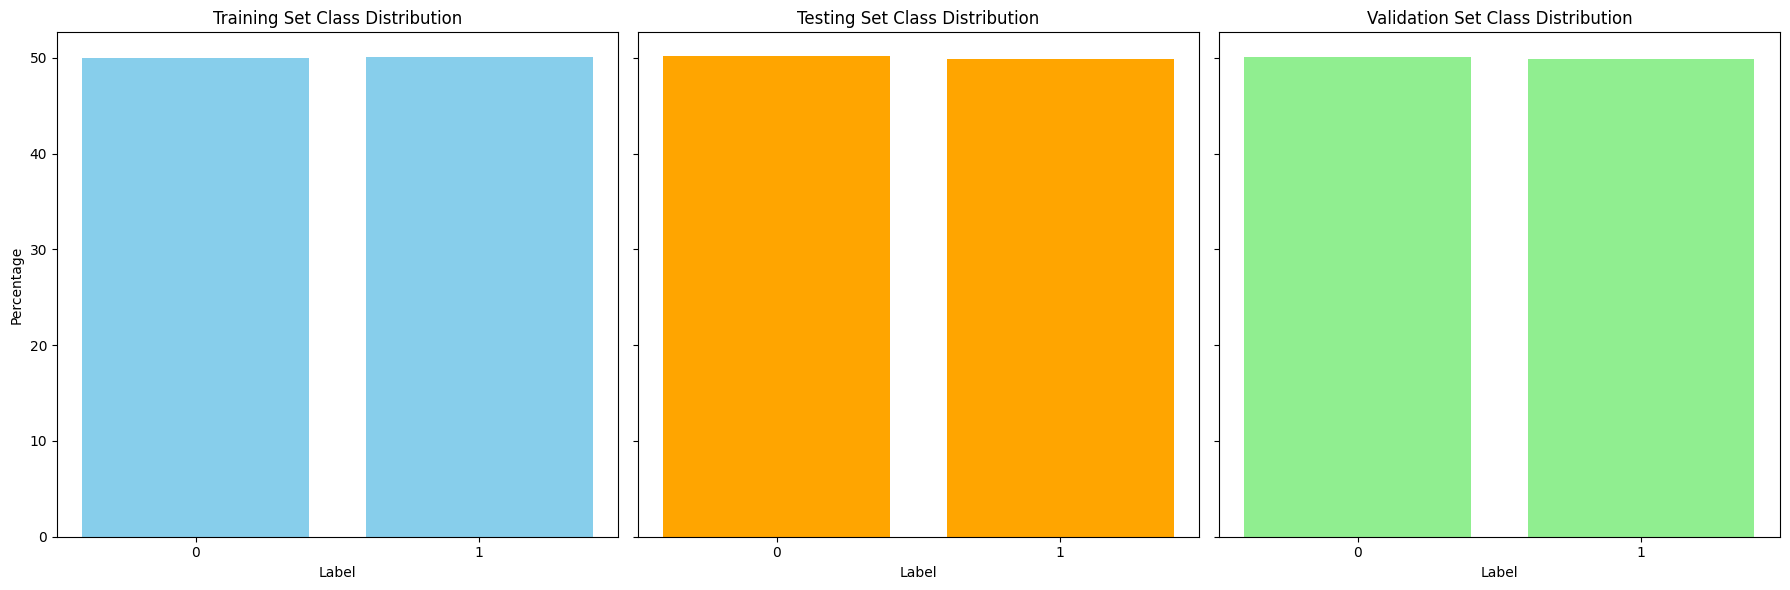

In [ ]:
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)
val_label_counts = Counter(valid_labels)

train_total = sum(train_label_counts.values())
test_total = sum(test_label_counts.values())
val_total = sum(val_label_counts.values())

train_percentages = {label: (count / train_total) * 100 for label, count in train_label_counts.items()}
test_percentages = {label: (count / test_total) * 100 for label, count in test_label_counts.items()}
val_percentages = {label: (count / val_total) * 100 for label, count in val_label_counts.items()}

labels = ['0', '1']
train_values = [train_percentages[int(label)] for label in labels]
test_values = [test_percentages[int(label)] for label in labels]
val_values = [val_percentages[int(label)] for label in labels]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].bar(labels, train_values, color='skyblue')
axs[0].set_title('Training Set Class Distribution')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Percentage')

axs[1].bar(labels, test_values, color='orange')
axs[1].set_title('Testing Set Class Distribution')
axs[1].set_xlabel('Label')
# axs[1].set_ylabel('Percentage') is not needed due to shared Y-axis

axs[2].bar(labels, val_values, color='lightgreen')
axs[2].set_title('Validation Set Class Distribution')
axs[2].set_xlabel('Label')
# axs[2].set_ylabel('Percentage') is not needed due to shared Y-axis

plt.tight_layout()
plt.show()

The bar charts provide a visual representation of the class distribution with the train,test and validation datasets. Illustrating that we have a balanced class. All of them exhibit an equal split of 50% positive reviews and 50% negative reviews, this balanced class helps to prevent bias.

### DESCRIPTIVE STATISTICS

In [ ]:
df_train['content_length_words'] = df_train['text'].str.split().str.len()
df_test['content_length_words'] = df_test['text'].str.split().str.len()
df_valid['content_length_words'] = df_valid['text'].str.split().str.len()

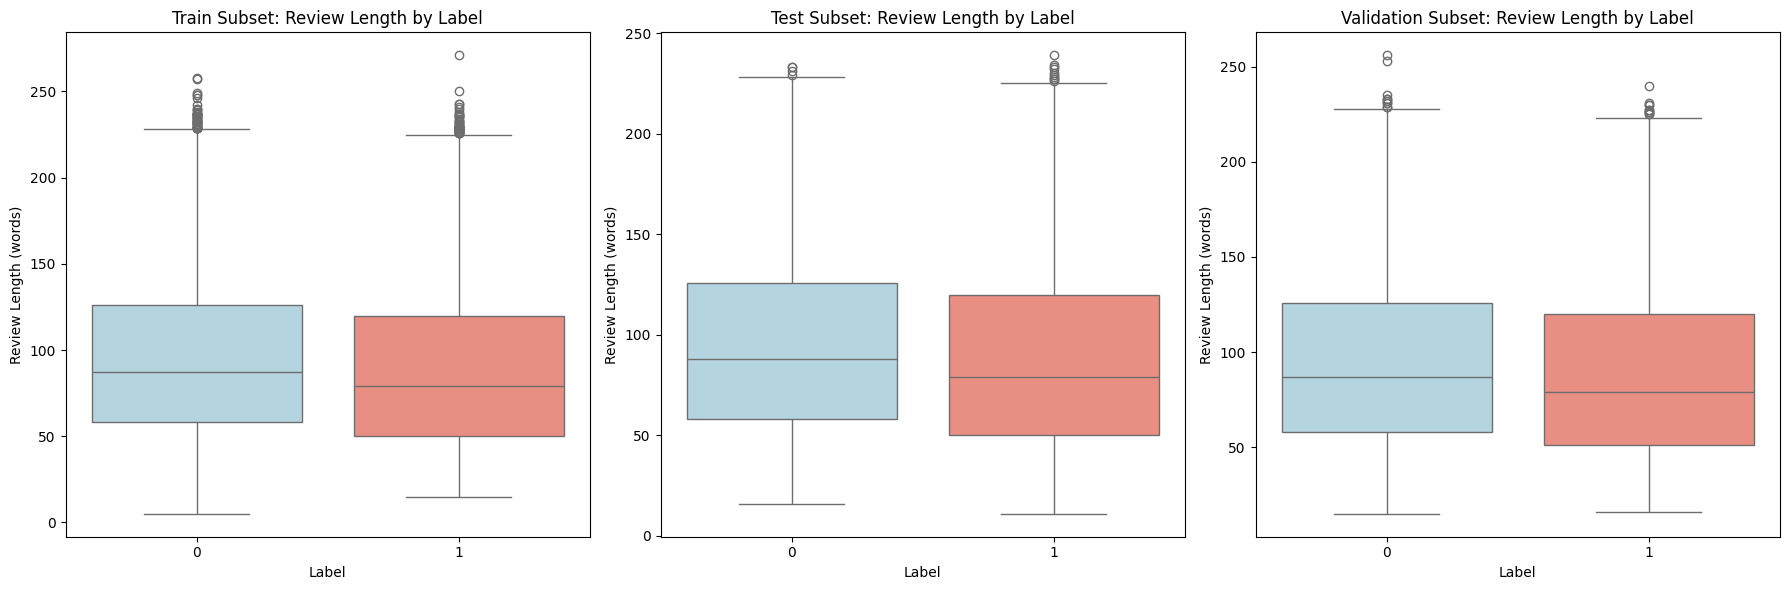

In [ ]:
# Define your color palette explicitly
palette = {0: "lightblue", 1: "salmon"}

plt.figure(figsize=(18, 6))

# Plot for the train subset
plt.subplot(1, 3, 1)
sns.boxplot(x='label', y='content_length_words', hue='label', data=df_train, palette=palette, dodge=False)
plt.title('Train Subset: Review Length by Label')
plt.xlabel('Label')
plt.ylabel('Review Length (words)')
plt.legend([],[], frameon=False)

# Plot for the test subset
plt.subplot(1, 3, 2)
sns.boxplot(x='label', y='content_length_words', hue='label', data=df_test, palette=palette, dodge=False)
plt.title('Test Subset: Review Length by Label')
plt.xlabel('Label')
plt.ylabel('Review Length (words)')
plt.legend([],[], frameon=False)

# Plot for the validation subset
plt.subplot(1, 3, 3)
sns.boxplot(x='label', y='content_length_words', hue='label', data=df_valid, palette=palette, dodge=False)
plt.title('Validation Subset: Review Length by Label')
plt.xlabel('Label')
plt.ylabel('Review Length (words)')
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

In these boxplots, the x axis represents the label 0 for negative reviews and 1 for positve reviews and y axis represents the length of the reviews in words. We could notice that the median and the quartiles for label 0 are slightly higher than for label 1 suggesting that negative reviews tend to be longer in train, test and validation datasets.

### WORDCLOUDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


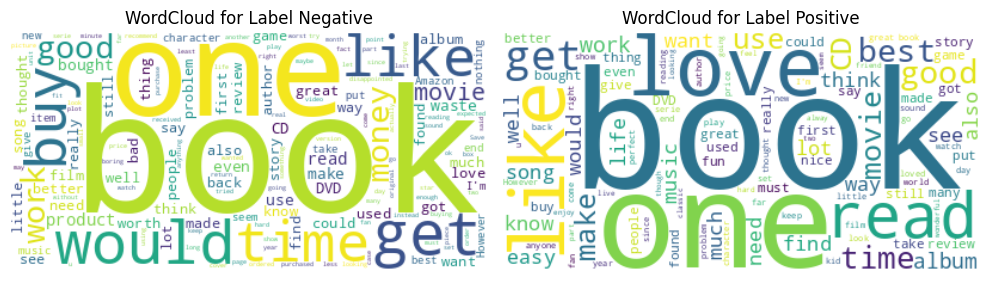

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

labels = {0: 'Negative', 1: 'Positive'}

label_data_lists = defaultdict(list)

for text, label in zip(train_data, train_labels):
    label_data_lists[label].append(text)

label_data = {label: ' '.join(texts) for label, texts in label_data_lists.items()}

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs = axs.flatten()

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

In the wordcloud of positive reviews we could see that the biggest words are ones that are more frequent than the small ones, based in this pattern we are going to list some words that are related with sentiment:love,good,best,better,great,easy,nice,well, wonderful. In the word cloud for negative reviews we could notice some words like: waste and problem. The presence of words like good in both clouds, means that is not a definitive indicator of sentiment without context because this could appear in phrases with negative connotations as well as postive ones.

### TF-IDF UNIGRAMS

TF-IDFvectorizer we use stop words to exclude comon English words, then we specify for unigrams and exclude terms that appear in more than 50% of the documents which are too common and also exlude terms that appear in less than 1% of the documents to remove very rare terms.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_df=0.5, min_df=0.01)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['text'])

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Split the TF-IDF matrix into positive and negative reviews based on the 'label' column
positive_indices = df_train.index[df_train['label'] == 1].tolist()
negative_indices = df_train.index[df_train['label'] == 0].tolist()

positive_tfidf = tfidf_matrix[positive_indices]
negative_tfidf = tfidf_matrix[negative_indices]

positive_word_scores = np.array(positive_tfidf.sum(axis=0)).flatten()
negative_word_scores = np.array(negative_tfidf.sum(axis=0)).flatten()

# Get indices of top words for each sentiment
top_positive_indices = positive_word_scores.argsort()[::-1]
top_negative_indices = negative_word_scores.argsort()[::-1]

# Print top 10 uni-grams for each sentiment with the scores
top_positive_unigrams = [(feature_names[i], positive_word_scores[i]) for i in top_positive_indices[:10]]
top_negative_unigrams = [(feature_names[i], negative_word_scores[i]) for i in top_negative_indices[:10]]

print("Top Positive uni-grams:")
for term, score in top_positive_unigrams:
    print(term, score)

print("\nTop Negative uni-grams:")
for term, score in top_negative_unigrams:
    print(term, score)

Top Positive uni-grams:
great 13045.84558486449
book 10526.305939842166
good 8373.920010534384
best 5939.226585706511
love 5556.243752373745
read 5124.769325536632
like 4384.561162342601
excellent 4205.680326963592
movie 4032.8067108743
just 3696.384815293229

Top Negative uni-grams:
book 8685.04453615853
don 5148.652568459017
good 5022.788752524414
like 4828.744366522035
just 4761.170920033824
money 4363.622266816176
buy 4184.395265290067
movie 4049.522812205066
bad 4023.123900787152
product 3906.1491134939884


In unigrams we could identify that **great** has the highest score, so it is a term that significantly characterizes positve reviews. Followed by  **best, love** and  **excellent**. In the negative reviews we could identify the word **bad** related to sentiment. The words **good** and **like** appear in both lists, so without context these words alone are not indicators of sentiment because this could be **good or not good,** so it depends on the sentence, which TF-IDF does not capture because it only considers word frequency.

### TF-IDF BIGRAMS

TF-IDFvectorizer we use stop words to exclude comon English words, then we specify for bigrams and exclude terms that appear in more than 50% of the documents which are too common and also exlude terms that appear in less than 1% of the documents to remove very rare terms.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 2), max_df=0.5, min_df=0.01)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['text'])

feature_names_bigrams = np.array(tfidf_vectorizer.get_feature_names_out())

# Split the TF-IDF matrix into positive and negative reviews based on the 'label' column
positive_indices = df_train.index[df_train['label'] == 1].tolist()
negative_indices = df_train.index[df_train['label'] == 0].tolist()

positive_tfidf = tfidf_matrix[positive_indices]
negative_tfidf = tfidf_matrix[negative_indices]

positive_word_scores = np.array(positive_tfidf.sum(axis=0)).flatten()
negative_word_scores = np.array(negative_tfidf.sum(axis=0)).flatten()


top_positive_indices_bigrams = positive_word_scores.argsort()[::-1][:10]
top_negative_indices_bigrams = negative_word_scores.argsort()[::-1][:10]

# Print top 10 bi-grams for each sentiment with the right scores
top_positive_bigrams = [(feature_names_bigrams[i], positive_word_scores[i]) for i in top_positive_indices_bigrams]
top_negative_bigrams = [(feature_names_bigrams[i], negative_word_scores[i]) for i in top_negative_indices_bigrams]

print("Top Positive Bi-grams:")
for term, score in top_positive_bigrams:
    print(term, score)

print("\nTop Negative Bi-grams:")
for term, score in top_negative_bigrams:
    print(term, score)

Top Positive Bi-grams:
read book 3925.213651812743
highly recommend 3867.1486208152282
great book 2898.2828058744385
year old 2818.019568925269
years ago 2170.4214379051696
book great 2061.094801696656
book read 1971.445605085554
long time 1948.7432557194309
good book 1932.2552989996263
recommend book 1734.4306500423957

Top Negative Bi-grams:
waste money 5740.629985307225
waste time 3683.1413569149195
don buy 3318.2149313583573
don waste 2965.7698003544137
save money 2753.913903482797
don know 2690.0671577026087
read book 2642.725936416117
year old 2315.578535250572
years ago 1477.5347335019856
reading book 1196.5896937128086


With bigrams we have a better understanding of the context. In postive reviews we have **highly recommend** which shows a strong feeling by recommending the product. The biagrmas as **great book** or **book great** reflects enjoyment about some books. In negative reviews we have **waste money** and **waste time** are clear expressions of dissatisfaction. **Don buy** and **don waste** may be are advisores against purchasing. We have words like **read book** which are common in both reviews but we can not infer something without context.

### NORMALIZED SCORES TO COMPARE UNIGRAMS VS BIGRAMS FOR POSITIVE AND NEGATIVE REVIEWS

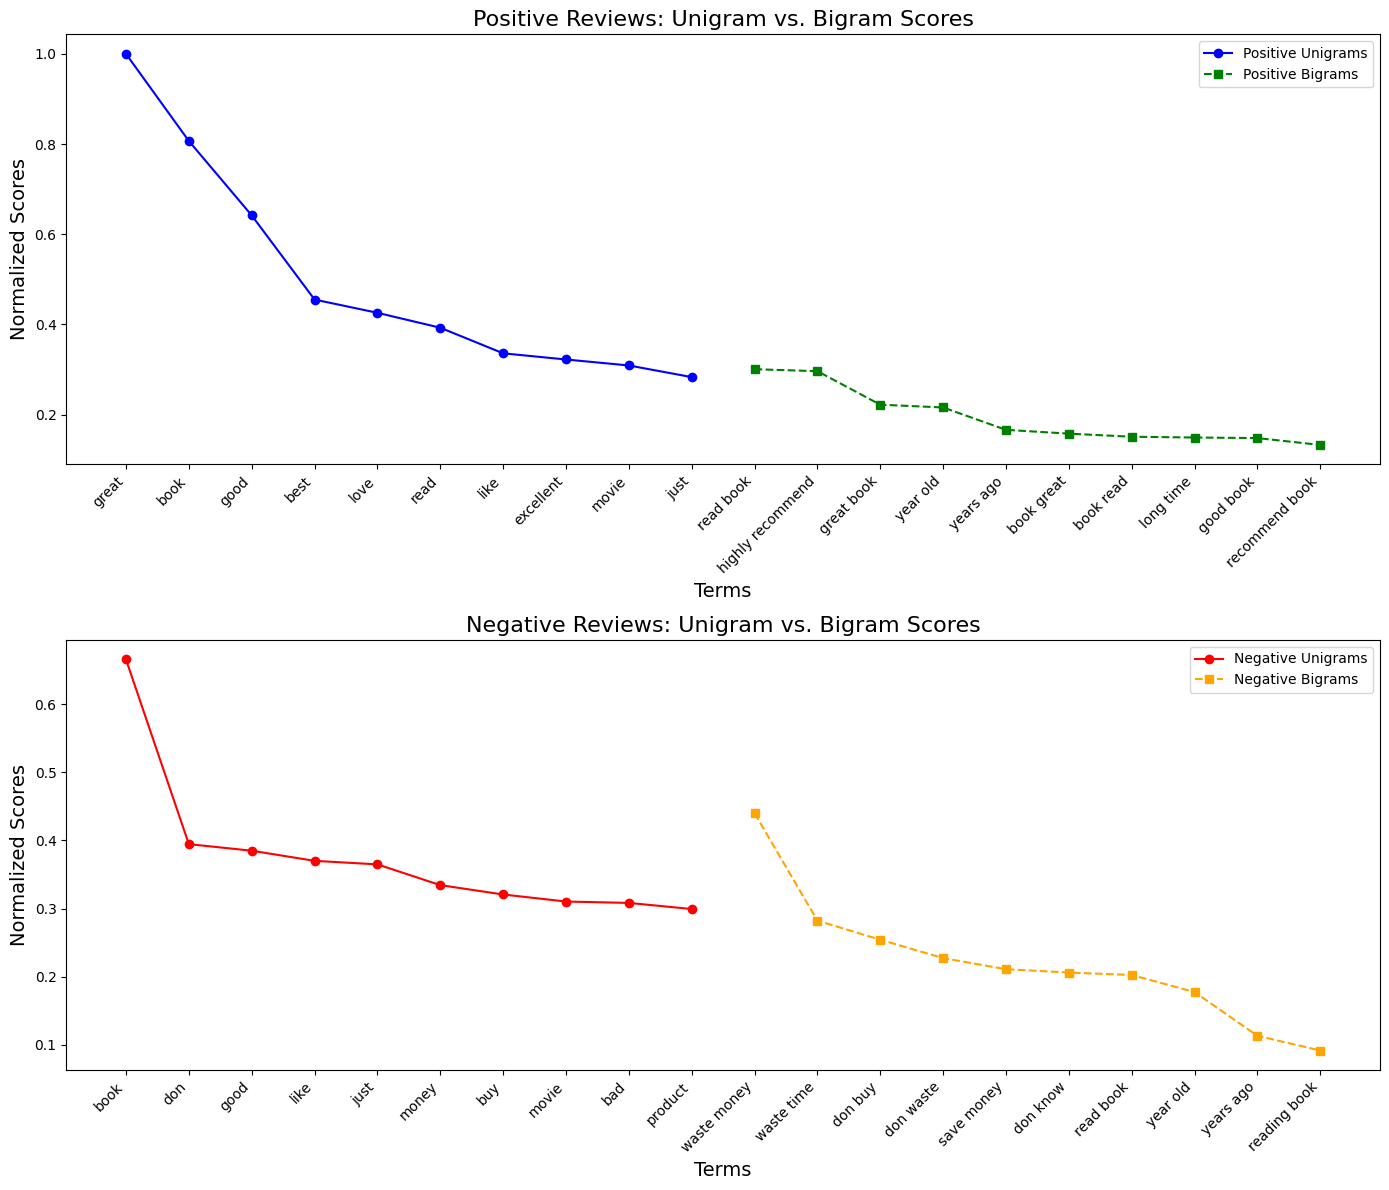

In [ ]:
# Extract scores from the tuples for normalization
positive_unigram_scores = [score for _, score in top_positive_unigrams]
negative_unigram_scores = [score for _, score in top_negative_unigrams]
positive_bigram_scores = [score for _, score in top_positive_bigrams]
negative_bigram_scores = [score for _, score in top_negative_bigrams]

# Combine all scores to find the global maximum for normalization
all_scores = positive_unigram_scores + negative_unigram_scores + positive_bigram_scores + negative_bigram_scores
max_score = max(all_scores)

# Normalize scores using the global maximum
def normalize_scores(scores, max_score):
    return [score / max_score for score in scores]

positive_unigram_scores_normalized = normalize_scores(positive_unigram_scores, max_score)
negative_unigram_scores_normalized = normalize_scores(negative_unigram_scores, max_score)
positive_bigram_scores_normalized = normalize_scores(positive_bigram_scores, max_score)
negative_bigram_scores_normalized = normalize_scores(negative_bigram_scores, max_score)

# Prepare terms for plotting
terms_positive_unigrams = [term for term, _ in top_positive_unigrams]
terms_negative_unigrams = [term for term, _ in top_negative_unigrams]
terms_positive_bigrams = [term for term, _ in top_positive_bigrams]
terms_negative_bigrams = [term for term, _ in top_negative_bigrams]

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Plotting Positive Reviews: Unigrams vs. Bigrams
ax[0].plot(terms_positive_unigrams, positive_unigram_scores_normalized, label='Positive Unigrams', marker='o', linestyle='-', color='blue')
ax[0].plot(terms_positive_bigrams, positive_bigram_scores_normalized, label='Positive Bigrams', marker='s', linestyle='--', color='green')

# Plotting Negative Reviews: Unigrams vs. Bigrams
ax[1].plot(terms_negative_unigrams, negative_unigram_scores_normalized, label='Negative Unigrams', marker='o', linestyle='-', color='red')
ax[1].plot(terms_negative_bigrams, negative_bigram_scores_normalized, label='Negative Bigrams', marker='s', linestyle='--', color='orange')

# Setting titles, labels, and legends
ax[0].set_title('Positive Reviews: Unigram vs. Bigram Scores', fontsize=16)
ax[1].set_title('Negative Reviews: Unigram vs. Bigram Scores', fontsize=16)

for a in ax:
    a.set_xlabel('Terms', fontsize=14)
    a.set_ylabel('Normalized Scores', fontsize=14)
    a.legend()
    for label in a.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


In the normalized TF-IDF scoring of text data from reviews, the normalization process adjusts the scores to fall within a 0 to 1 range for the purpose of comparison. This allows us to directly compare the relative importance of unigrams and bigrams in expressing sentiments in reviews.



From the positive reviews, it appears that unigrams generally have higher normalized scores compared to bigrams. The term "great" leads with the highest normalized score among unigrams, indicating its prominence in positive sentiments. It is followed by other positive terms such as **good**,**best**, and **love**, as well as **excellent**, which further reinforce positive sentiments. Interestingly, when we get to the bigrams, **highly recommend**, **great book**,**book great**, and **recommend book** appear, suggesting that specific recommendations and positive comments about books are common in positive reviews.


In negative reviews, the unigram **bad** directly conveys negative sentiment. The term **money **by itself is ambiguous and requires context to understand its sentiment implication. However, the bigram **waste money **is the most common and has a high normalized score, clearly expressing dissatisfaction among reviewers,this particular phrase is a strong indicator of negative sentiment.


## RANDOM CLASSIFIER PERFORMANCE

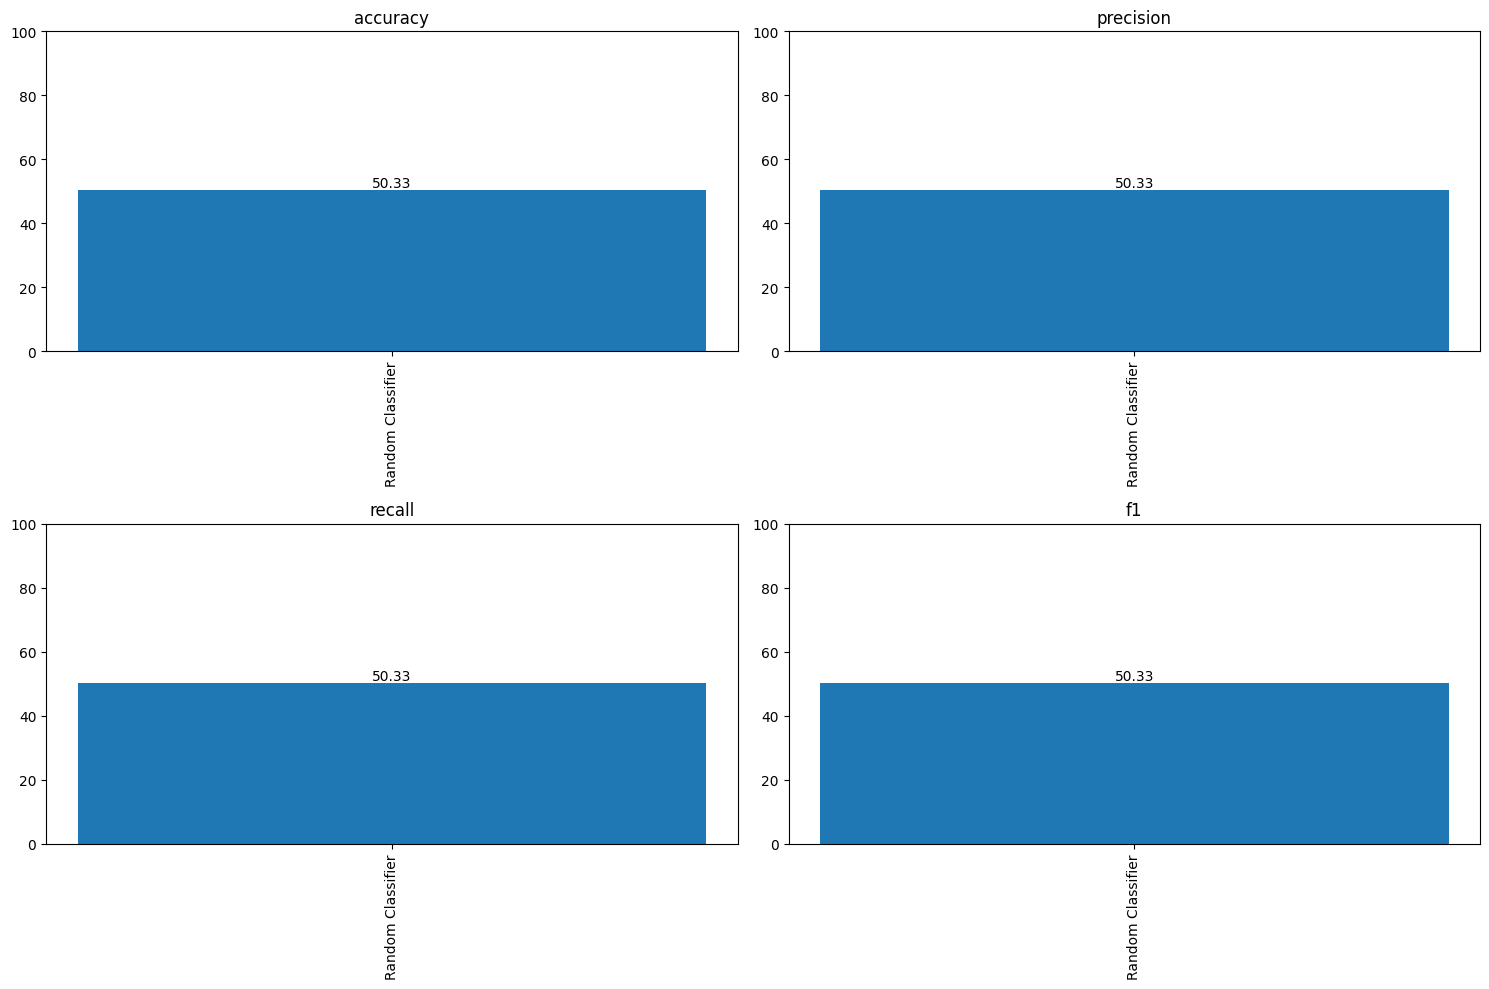

In [ ]:
def random_binary_classifier(X):
    n_obs = len(X)
    predictions = [random.choice([0, 1]) for _ in range(n_obs)]
    return np.array(predictions)

test_preds_random = random_binary_classifier(df_test['text'])

metrics_test= Metrics()
metrics_test.run(df_test['label'], test_preds_random, "Random Classifier")
metrics_test.plot()

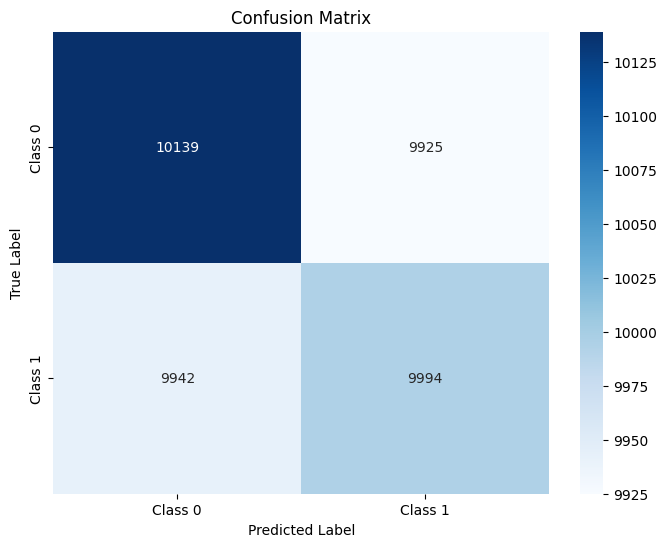

In [ ]:
show_confusion_matrix(df_test['label'], test_preds_random)

In random binary classifier that predicts 0 for negative reviews and 1 for postive reviws with equal probability for each observation, the expected accuracy is 50%, because on average, the classifier would be correct half the time. In the confussion matrix we could see that true postives are 10,139 so the class was 0 and the classifer correctly predicted as 0, the true negatives are 9,994 indicates the number of instances where the class was 1 and the classifier correclty predictes as 1. The false negatives are 9,942 the class was 1 but the classifer incorrectly predicted as 0. False positves are 9,925 indicates the class was 0 but the classifier incorrectly predicted 1. So, we could see the case that all the values are close to 10.000, for this reason all the metrics are expected to be 50% if we do the calculations based on these numbers.

## BASELINE IMPLEMENTATION

Using regex, we defined patterns to capture positive and negative sentiments in text data. The positive pattern (positive_regex) lists adjectives commonly associated with positive sentiment, while two negative patterns were created: one (negative_regex) lists adjectives indicative of negative sentiment, and the other (negative_but_regex) targets instances where positive adjectives are followed by "but," often signifying a negative turn in sentiment. This approach aimed to classify reviews as positive, negative, or not classified. However, due to the limited complexity of these patterns, many reviews that contained subtler sentiments or used vocabulary outside of these patterns could not be accurately classified, leading to a significant portion being marked as not classified. Consequently, the performance of this classification method did not surpass that of a more nuanced model, such as a random forest classifier, due to its inability to capture the full range of expressions of sentiment.
##### positive_regex
```regex
\b(?:excellent|great|best|love|marvelous|superb|spectacular|awesome|brilliant|outstanding|good|phenomenal|remarkable|exceptional|incredible|amazing|fantastic|terrific|splendid|extraordinary|stupendous)\b
```
##### negative_regex
```regex
\b(?:awful|horrible|terrible|dreadful|bad|poor|subpar|inferior|abysmal|atrocious|lousy|pathetic|disappointing|unsatisfactory|underwhelming|lackluster|mediocre|ordinary|average|middling)\b

```
##### negative_but_regex

```regex

\b(?:good|marvelous|terrific|amazing|incredible|fantastic|phenomenal|stupendous|alright)\b.*?\bbut\b
```
To address this limitation and improve classification performance, we applied a comprehensive preprocessing step before model training. This preprocessing involved removing all non-alphanumeric characters, converting text to lowercase, and applying stemming to reduce words to their root forms.Following preprocessing, we constructed a pipeline combining TfidfVectorizer and Logistic Regression. The TfidfVectorizer transforms text into a matrix of TF-IDF features, emphasizing words that are important to specific documents and less so across the entire corpus. Logistic Regression then uses these features to predict the sentiment label.




In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

# We decided to use only a subsample of the data because the stemming part, when using hundreds of thousands
# of reviews was getting a little overwhelmed and the notebook took too much time to run this specific cell.
# As this is only to set a baseline model, we decided that 30k and 6k was a good baseline number, which
# is also 0.75% of the complete dataset that we have so it is an actually decent baseline regarding
# the number of samples used (we refer to 0.75% of the 4M dataset, not of the 10% subsample that we are running).

df_train_subsample = df_train.sample(n=30000, random_state=SEED)
df_test_subsample = df_test.sample(n=6000, random_state=SEED)

def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

def tokenize(text):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers = abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                stems.append(porter.stem(lowers))
    return stems

train_data_stemming = [' '.join(tokenize(text)) for text in df_train_subsample['text']]
test_data_stemming = [' '.join(tokenize(text)) for text in df_test_subsample['text']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'clf__C': 0.1, 'tfidf__max_df': 0.5, 'tfidf__min_df': 15, 'tfidf__ngram_range': (1, 2)}


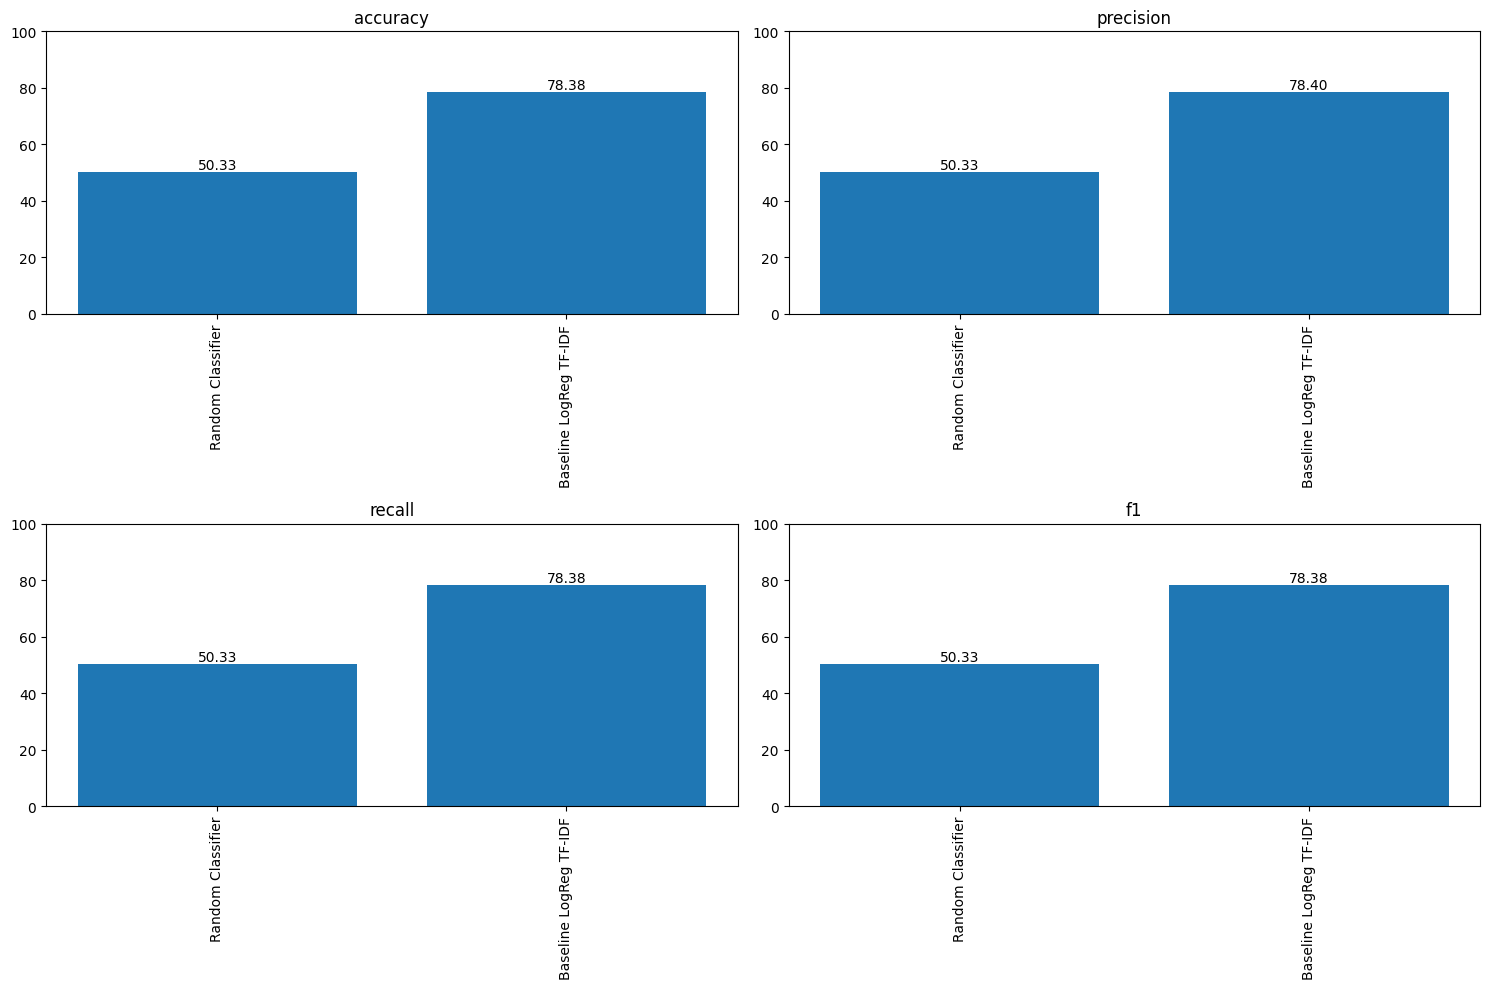

In [ ]:
# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Define the parameter grid, now including C values, ngram_range options, and min_df values
# We first run a grid_search with the parameters you can see in the comments. We only run it with
# the best parameters we found from now on.

param_grid = {
    'clf__C': [0.1],# [0.001, 0.01, 0.1],  # C values to try
    'tfidf__ngram_range': [(1,2)],# [(1, 1), (1, 2), (2, 2)],  # ngram ranges to try
    'tfidf__min_df': [15],# [5, 15, 0.01],  # min_df values to try
    'tfidf__max_df': [0.5] #[0.5, 0.4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# We fit the GridSearchCV object on the training data
grid_search.fit(train_data_stemming, df_train_subsample['label'])

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# We predict on the testing set with the best found parameters but we do it directly.
# The reason for this is that the complete dataset is very big so fitting the best model
# to the full training data again just to use 100% of it instead of 80%, given that in this case
# we are just preparing a baseline model, we want to save a few minutes off of the runtime
# by going directly to .predict from the grid_search itself instead of fitting a best model
# in between.

test_preds_baseline = grid_search.predict(df_test_subsample['text'])

metrics_test.run(df_test_subsample['label'], test_preds_baseline, "Baseline LogReg TF-IDF")
metrics_test.plot()

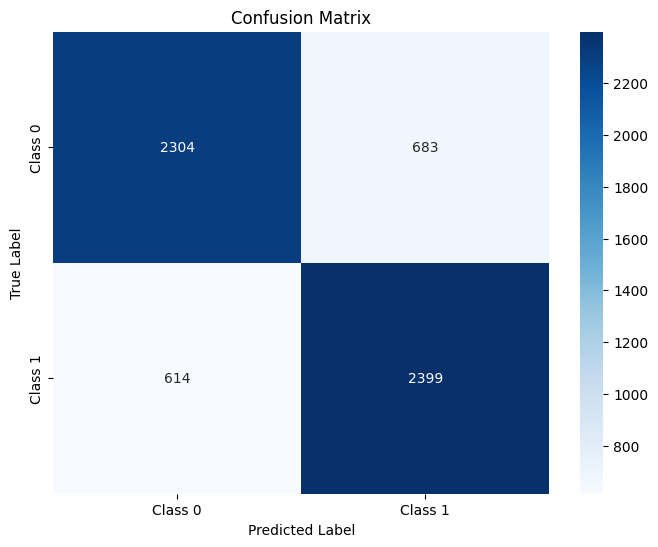

In [ ]:
show_confusion_matrix(df_test_subsample['label'], test_preds_baseline)

In the baseline because was computationally expensive to apply stemming, we decide to create subsamples from the training and testing datasets, so at the end it uses 30.000 samples for training and 6.000 for testing. We have a function that removes all non alphanumeric characters from a string, checks if a word is an abbreviation and if not converts to lowercase, remove stopwords, filters out non letter tokens and stems the remaining tokens. Then we have a pipeline which set up with is with TfidfVectorizer and LogisticRegression. Regarding the confussion matrix provided, it displays the performance of the binary classification. In true positives we get 2.304, false negatives are 683, false positives 614 and true negatives 2399. This model performs significantly better than random guessing with 78.38% of accuracy, as we could see that the true positives and true negatives are greater than the false negatives and false positives respectively. Despite its simplicity, this model showed an improvement over the random classifier, demonstrating that even straightforward algorithms can perform well with proper preprocessing. Specially the false positives and negatives decrease drasticaly.

This is already a very decent improvement on the random classifier and it means that our baseline model is clearly capturing some trend in the data which allows it to classify with a much better performance than a random guess. As far as the baseline model get, we consider it a solid starting point. Additionally, as the results are decent but this model is still pretty basic and simple, we will consider as "not good enough" results for anything below those scores when comparing our further models with this baseline.

# PART 2: DATA SCIENTIST CHALLENGE

## BERT MODEL WITH LIMITED DATA

We first try to use the full BERT model (the uncased version that can be found in https://huggingface.co/google-bert/bert-base-uncased#limitations-and-bias).

We are currently being able to use the premium gpus from colab so we want to try to use the full BERT model and see how well it can perform.

After trying to use the full BERT model we realized that Google Colab runtime units run out really fast so we had no option but to use the distilled version of BERT, which can be found here: https://huggingface.co/distilbert/distilbert-base-uncased.

As the distilled version of BERT is a smaller version of the original model, we can use it to train the model with the full dataset and the current computing capacity that we have without it being an impossible task.

In [ ]:
Dbert = "distilbert-base-uncased"

# config = DistilBertConfig.from_pretrained(Dbert)
tokenizer = DistilBertTokenizer.from_pretrained(Dbert)
distilBERT = TFDistilBertModel.from_pretrained(Dbert)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


We decided to use max_length of 128 for 2 main reasons:
- The mean and median lengths of our reviews are around 80 to 90 and the maximum length is 272 so 128 is a good size in between.
- 128 is also a power of 2 and as such optimizes gpu processes when running the keras models.

In [ ]:
max_length = 128

In [ ]:
"""
First we prepare a dataset where there are 16 positive reviews and 16 negative reviews
from the training dataframe.
Given the small size of this sample we made sure that it was split 50/50 between labels 0 and 1
to maximize training examples from both labels (from a squared loss maximization perspective).
"""

df_train_positives = df_train[df_train['label'] == 1].copy()
df_train_negatives = df_train[df_train['label'] == 0].copy()

df_train_positives_sample = df_train_positives.sample(n=16, random_state=SEED)
df_train_negatives_sample = df_train_negatives.sample(n=16, random_state=SEED)

df_train_limited = pd.concat([df_train_positives_sample, df_train_negatives_sample])

df_train_limited = df_train_limited.sample(frac=1, random_state=SEED).reset_index(drop=True)

display(df_train_limited.head())

,label,text,content_length_words
0,1,The second CD in my Elvis collection. The seco...,102
1,1,Surprise! Surprise! Surprise! Surprise! What a...,94
2,1,Machiavelli Machiavelli Machiavelli Machiavell...,27
3,0,Grandrich ES-101 Full Spectrum Floor Lamp Gran...,113
4,0,Lasts for 6 mo Lasts for 6 mo Lasts for 6 mo L...,39


Now we define a function that we will use all throughout this notebook to transform the dataframe objects to tensorflow dataset objects, which make it very easy to perform batching and shuffling in preparation of the models' fittings.

In [ ]:
def tf_dataset_creator(df):
  tokenizer = DistilBertTokenizer.from_pretrained(Dbert)
  temp_encodings = tokenizer(df['text'].tolist(), truncation=True, padding=True, max_length=max_length)
  temp_labels = tf.convert_to_tensor(df['label'].tolist())
  tf_df = tf.data.Dataset.from_tensor_slices((dict(temp_encodings), temp_labels))

  return tf_df

In the following cell the efforts to load the pre-processed tf datasets can be appreciated.

Colab processes very slowly when it comes to CPU so being able to load the tensorflow datasets from a drive-saved document was essential to run the model with more than 15-20% of the whole dataset that we got from Hugging Face.

The notebook crashed several times when trying to process the whole dataset (without any type of subsampling) to a tensorflow dataset. Probably to Colab's runtime limitations. We tried to do it, it just didn't work. And the solutions we tried to process it on our computers overnight and then load them here did not work either.

This is the main reason why we had to run the model on 15-20% of the whole datset (which still leaves us with a more than decent 500k row training dataset), or even reaching down to 10%, with a remaining training dataset of around 300k of reviews (still well enough to get robust results).

In [ ]:
tf_list = ['tf_train', 'tf_train_limited', 'tf_test', 'tf_valid']

if LOAD_TF == True:
  filepath_tf_train = f"{TF_PATH}/tf_train.tfrecord"
  filepath_tf_train_limited = f"{TF_PATH}/tf_train_limited.tfrecord"
  filepath_tf_test = f"{TF_PATH}/tf_test.tfrecord"
  filepath_tf_valid = f"{TF_PATH}/tf_valid.tfrecord"

  tf_train = load_dataset_from_tfrecord(filepath_tf_train)
  tf_train_limited = load_dataset_from_tfrecord(filepath_tf_train_limited)
  tf_test = load_dataset_from_tfrecord(filepath_tf_test)
  tf_valid = load_dataset_from_tfrecord(filepath_tf_valid)
elif SAVE_TF == True:
  tf_train = tf_dataset_creator(df_train)
  tf_train_limited = tf_dataset_creator(df_train_limited)
  tf_test = tf_dataset_creator(df_test)
  tf_valid = tf_dataset_creator(df_valid)

  filename_train = f"{TF_SAVE_PATH}/tf_train.tfrecord"
  filename_train_limited = f"{TF_SAVE_PATH}/tf_train_limited.tfrecord"
  filename_test = f"{TF_SAVE_PATH}/tf_test.tfrecord"
  filename_valid = f"{TF_SAVE_PATH}/tf_valid.tfrecord"

  tfrecord_writer(tf_train, filename_train)
  tfrecord_writer(tf_train_limited, filename_train_limited)
  tfrecord_writer(tf_test, filename_test)
  tfrecord_writer(tf_valid, filename_valid)
else:
  tf_train = tf_dataset_creator(df_train)
  tf_train_limited = tf_dataset_creator(df_train_limited)
  tf_test = tf_dataset_creator(df_test)
  tf_valid = tf_dataset_creator(df_valid)

# In the end the only part running has to be the "else:" as we were not able to export the tf datasets
# in a usable format.

# display(tf_train_limited)

We next define also a function which will be used all throughout the notebook as well to establish the bert model that we are going to use.

As we want to be able to re-use those models separately afterwards if we need to, we decided to got with a modular approach. As we establish the main architecture of the model in this same place for all the parts, we easily can get the "same" model but with different names, effectively allowing us to differentiate which model was used and trained in each part and also to easily re-use them afterwards if needed.

This architecture is not the most complicated one but it is a solid base from which, with additional time to invest in upgrading the model, we would start to work upon. As it does already a very decent job when used together with the distilBERT, we are quite happy with its performance.

Right now, what is crucial is the fact that we use a dropout layer to avoid or, at least, minimize over-fitting. This is really important because we will be using the model with trainable=True on the rest of this notebook so we really need that the model can deal with preventing overfitting.
Setting the model to be trainable means that the model will be fine-tuned to our specific training dataset. This is really important because the distilBERT is not necessarily trained on our dataset or, at least, our data only represents a small percentage of the training data for it. As a result, it is important to fine-tune it to improve its performance on our dataset. Even in this case, though, we do want to prevent over-fitting with this feature as we said.

As our task is a binary classification, we close the model with a 1-node Dense layer with sigmoid activation and glorot uniform initializer. Pretty standard stuff for binary classification tasks. This combinations has proven to work well during our first tries so we kept it.

In [ ]:
def get_BERT_model(bert_to_use, do_rate, max_length, trainable=False):
    bert_to_use.trainable = trainable

    input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = bert_to_use(input_ids=input_ids, attention_mask=attention_mask)

    hidden_state = embedding_layer[0]

    drop = Dropout(do_rate)(hidden_state[:, 0, :])

    output = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(drop)

    bert_model = Model(inputs=[input_ids, attention_mask], outputs=output)

    return bert_model

BEWARE: Right now the load feature is designed for model loading but it doesn't work quite right. We instead decided to go for saving the weights of each model we fit so if the loading feature needs to be used it first has to be tuned to load the weights of the model instead of trying the model itself. Right now the load is more just a place-holder for future improvements of the notebook.

That being said, the model is fitted in a basic manner here, both when save_model==True and when save_model!=True. The batch size for the training dataset was set to 1 so that each of the 32 labeled examples that we get to use in this part are used specifically. Batch sizes for validation and testing datasets are set to much larger quantities as they are used in their 100% all the time (after the appropriate 10% subsampling we use for the whole notebook, obviously). As a result, we find that epochs from this first fitting, for example, took only a couple of seconds to go through the training data and instead most of the time spent on each of them was for the validation set which stands all the time at a very decent 54k labeled reviews.

We also define Adam with a conservative learning rate, which already worked fine through all the first tries so we kept it.

Binary Crossentropy also is a pretty standard setting for binary classification tasks which worked the best on the first fittings and we decided to go with it from then onwards.

We decided to use 4 main metrics inside the model fittings and accuracy, precision, recall and AUC were the more standard. We use accuracy and AUC to guide our decisions about the validation fittings in a more general way, while we keep an eye on precision and recall to make sure that the model is not getting good AUC or accuracy scores by exploiting class imbalances or other possible pitfalls. This is not a problem when the models start going above 80% and using enought training data (as our data already doesn't have class imbalances) but for the first models like in this part, we had instances where the model would perform sufficiently better than the random classifier but would do it by predicting nearly all of the observations to one class and then just predicting some very clear examples to the other class. This was not noticeable on the accuracy scores but it did show on the precision and recall scores (specially recall in that particular instance), and also of course if was very evident when looking at the confusion matrix.

In [ ]:
batch_size_train = 1
batch_size_valid = 128
batch_size_test = 64

if LOAD_MODEL == True:
  bert_model1 = load_model(f"{MODEL_LOAD_PATH}/BERT_2a")
elif SAVE_MODEL == True:
  bert_model1 = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)
  bert_model1.summary()

  batch_size_train = 1
  batch_size_valid = 128
  batch_size_test = 64

  tf_train_limited = tf_train_limited.shuffle(len(df_train_limited)).batch(batch_size_train)
  tf_valid = tf_valid.batch(batch_size_valid)
  tf_test = tf_test.batch(batch_size_test)

  bert_model1.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

  bert_model1.fit(tf_train_limited, validation_data=tf_valid, epochs=EPOCHS)
  bert_model1.save_weights(f"{MODEL_SAVE_PATH}/BERT_2a")
else:
  bert_model1 = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)
  bert_model1.summary()

  batch_size_train = 1
  batch_size_valid = 128
  batch_size_test = 64

  tf_train_limited = tf_train_limited.shuffle(len(df_train_limited)).batch(batch_size_train)
  tf_valid = tf_valid.batch(batch_size_valid)
  tf_test = tf_test.batch(batch_size_test)

  bert_model1.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

  bert_model1.fit(tf_train_limited, validation_data=tf_valid, epochs=EPOCHS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                       

In [ ]:
# valid_preds = bert_model1.predict(tf_valid)
# valid_preds = np.round(valid_preds).astype('int32').flatten()

labels_valid = df_valid['label'].to_numpy().astype('int32')

# metrics_val = Metrics()
# metrics_val.run(labels_valid, valid_preds, "BERT Model Limited")
# metrics_val.plot()
# show_confusion_matrix(labels_valid, valid_preds)

625/625 [==============================] - 42s 64ms/step


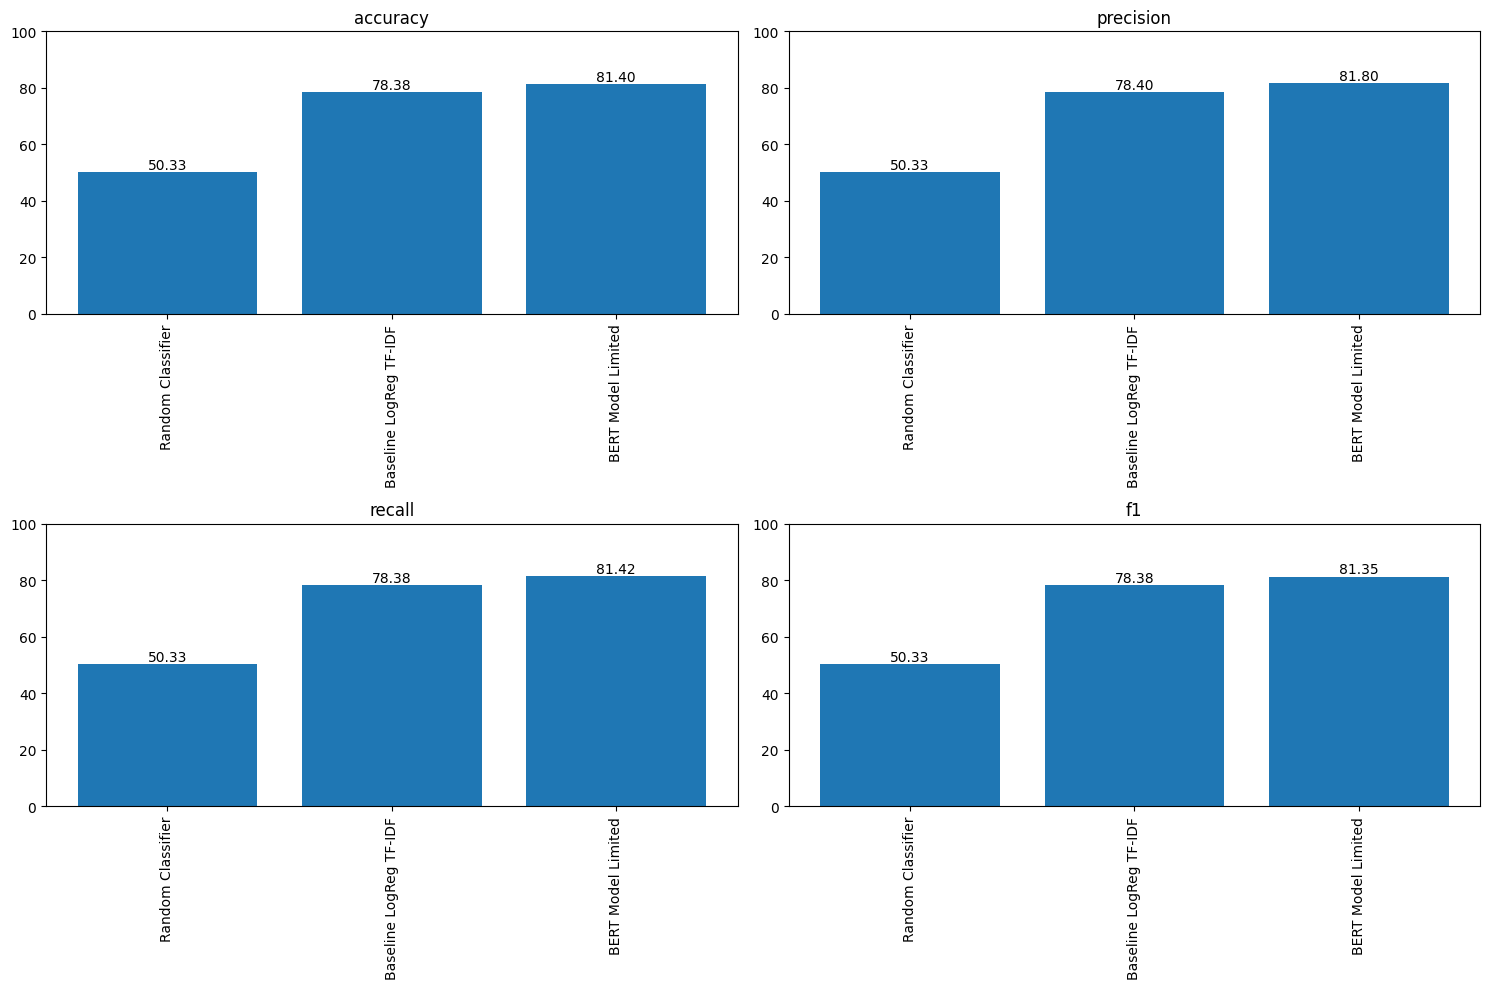

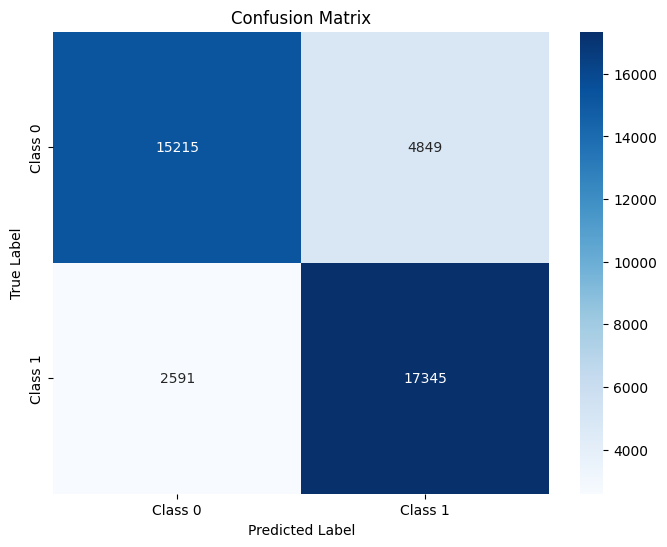

In [ ]:
test_preds = bert_model1.predict(tf_test)
test_preds_limited = np.round(test_preds).astype('int32').flatten()

labels_test = df_test['label'].to_numpy().astype('int32')

metrics_test2 = Metrics()
metrics_test2.run(labels_test, test_preds_limited, "BERT Model Limited")
# metrics_test2.plot()

metrics_test.run(labels_test, test_preds_limited, "BERT Model Limited")
metrics_test.plot()

show_confusion_matrix(labels_test, test_preds_limited)

We are quite happy with the results we finally got from this first fitting. We are already above the baseline model. Not much, but taking into account that here we are only using 32 labeled examples, we are satisfied with the performance of our model regarding this first part.

It has a slight tendency to missclassify negative reviews a little bit more than positive reviews although this could be due to the specific 16 labeled examples we got. Maybe with a different seed this could change.
Actually, with a different seed, the model could arrive at much worse results. If the specific seed takes samples that contain very little generalizable information about what makes a review positive or negative we could then be facing a situation where this first model performs very poorly.

In short, the scores are good for our seed, but they could potentially have a lot of variability depending on the seed given the small amount of the sample we are taking from the training data.

## DATASET AUGMENTATION

For this part we use the Synonym Augmenter from nlpaug. This function takes a text and creates different versions of it by changing the words for some synonyms they might have. As we are using an all english dataset, this function is very useful because it already supports a pre-prepared "dictionary" (wordnet). As a result, the implementation is very simple, yet effective.

This allows us to easily augment our 32 row dataset to 5 times its size.

In [ ]:
def augment_dataset(data, augmenter, num_augmented=2):
    data_augmented = data.copy()
    augmented_data = []

    for index, row in data_augmented.iterrows():
        for _ in range(num_augmented):
            augmented_data.append([row['label'], ' '.join(augmenter.augment(row['text']))])

    augmented_data_df = pd.DataFrame(augmented_data, columns=['label', 'text'])

    return augmented_data_df

aug = naw.SynonymAug(aug_src='wordnet')
df_train_limited_aug = augment_dataset(df_train_limited, aug, num_augmented=5)
df_train_limited_aug.head()

display(df_train_limited_aug)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,label,text
0,1,The second CD in my Elvis collection. The seco...
1,1,The second CD in my Elvis collection. The seco...
2,1,The 2nd CD in my Elvis collection. The second ...
3,1,The second CD in my Elvis ingathering. The sec...
4,1,The second CD in my Elvis assemblage. The 2d C...
...,...,...
155,0,Ditto mark everyone else Ditto everyone else D...
156,0,Ditto everyone else Ditto everyone else Ditto ...
157,0,Ditto everyone else Ditto mark everyone else D...
158,0,Ditto everyone else Ditto everyone else Ditto ...


The fitting this time share most of its structure and realization with the fitting of the model in the previous part.

The main and only difference is that this time we set the batch size for the training dataset to 2 instead of 1 as we are already dealing with a dataset of 160 reviews, which is not too much, but that's why we chose 2 instead of even a higher number for the batch size.

The rest of the parameters stay the same as the optimization of hyper-parameters was done in very early fittings and we took those parameters as given from then onwards. They will continue to stay the same for the rest of the models as we didn't have time to optimize each set of parameters for each model fitting in each part.

In [ ]:
batch_size_train = 2

if LOAD_MODEL == True:
  bert_model2 = load_model(f"{MODEL_LOAD_PATH}/BERT_2b")
elif SAVE_MODEL == True:
  bert_model2 = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)
  bert_model2.summary()

  batch_size_train = 2

  tf_train_limited_aug = tf_dataset_creator(df_train_limited_aug)

  tf_train_limited_aug = tf_train_limited_aug.shuffle(len(df_train_limited_aug)).batch(batch_size_train)

  bert_model2.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

  bert_model2.fit(tf_train_limited_aug, validation_data=tf_valid, epochs=EPOCHS)
  bert_model2.save_weights(f"{MODEL_SAVE_PATH}/BERT_2b")
else:
  bert_model2 = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)
  bert_model2.summary()

  batch_size_train = 2

  tf_train_limited_aug = tf_dataset_creator(df_train_limited_aug)

  tf_train_limited_aug = tf_train_limited_aug.shuffle(len(df_train_limited_aug)).batch(batch_size_train)

  bert_model2.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

  bert_model2.fit(tf_train_limited_aug, validation_data=tf_valid, epochs=EPOCHS)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

In [ ]:
# valid_preds = bert_model2.predict(tf_valid)
# valid_preds = np.round(valid_preds).astype('int32').flatten()

labels_valid = df_valid['label'].to_numpy().astype('int32')

# metrics_val.run(labels_valid, valid_preds, "BERT Augmented")
# metrics_val.plot()
# show_confusion_matrix(labels_valid, valid_preds)

625/625 [==============================] - 42s 64ms/step


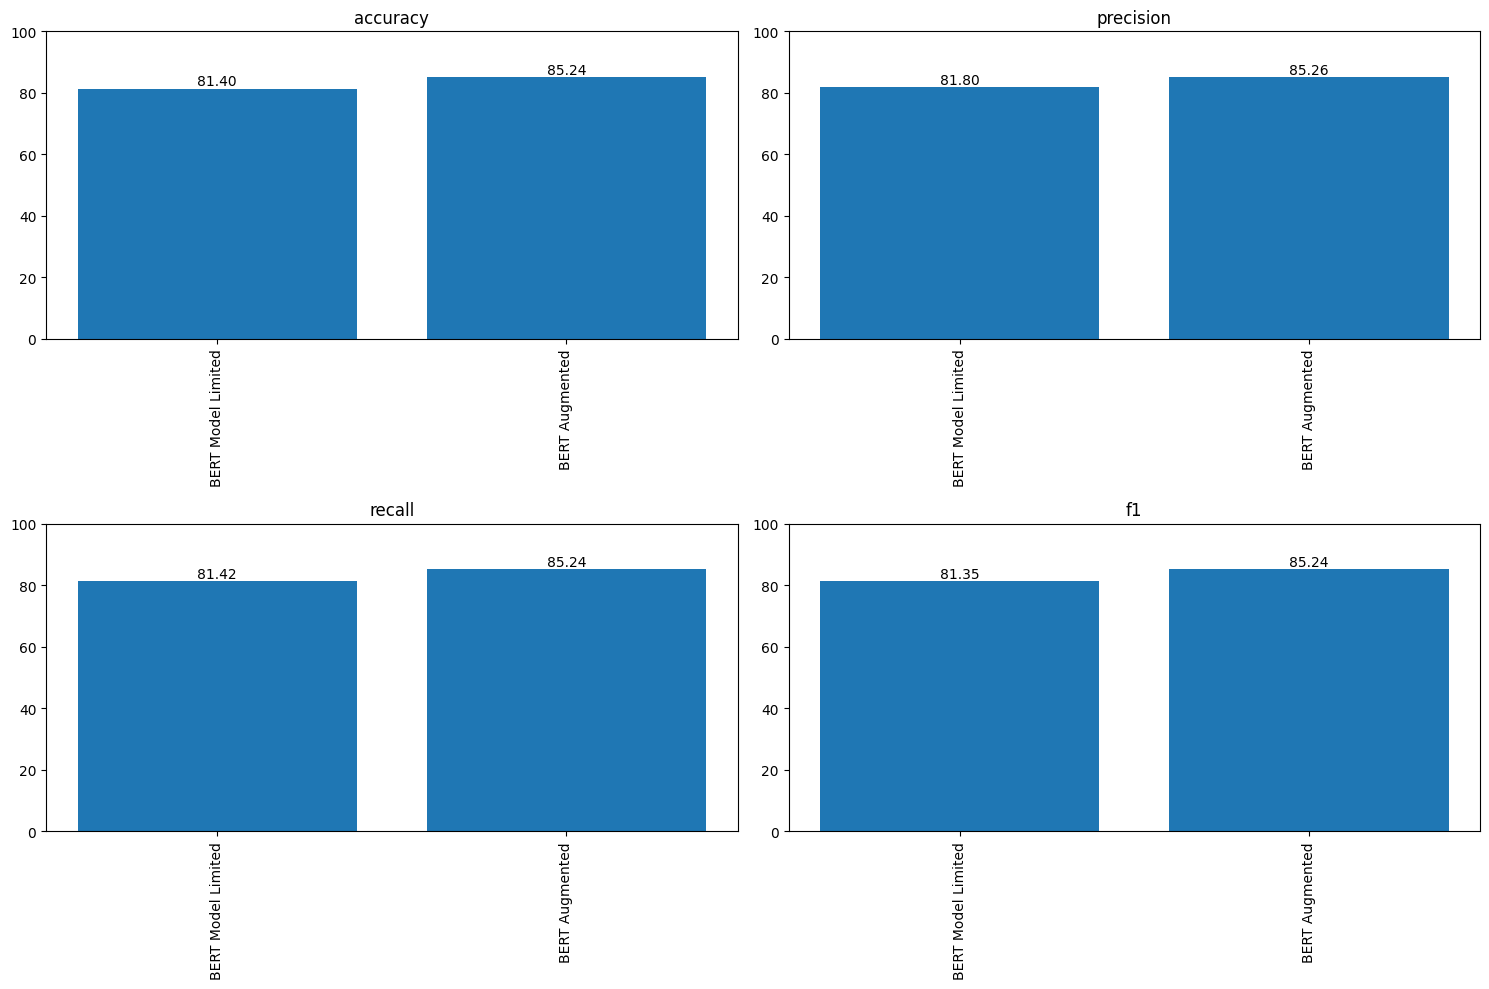

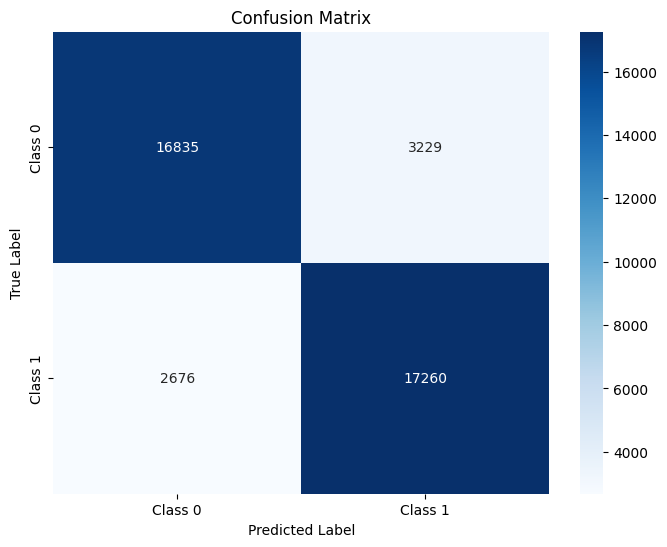

In [ ]:
test_preds = bert_model2.predict(tf_test)
test_preds_limited_aug = np.round(test_preds).astype('int32').flatten()

labels_test = df_test['label'].to_numpy().astype('int32')

metrics_test2.run(labels_test, test_preds_limited_aug, "BERT Augmented")
metrics_test2.plot()

show_confusion_matrix(labels_test, test_preds_limited_aug)

This augmented model does improve the score significantly over the first model. These are very good news because right now we were only using a 5x augmentation factor, but we could use a much higher factor to get quite solid results.

That being said, again these results do have even higher variability than the ones in the previous part. If the 32 samples taken for a specific random seed don't provide much useful information for the classifier, then this model is going to perform very poorly, potentially not even improving scores with respect to the previous model.

In short, with the random seed we are using, as the 32 samples are quite good (we did get lucky about that), this model is capable of improving the scores significantly, which is very good news and really showcases the potential of this type of data augmentation.

## ZERO-SHOT LEARNING WITH LLM

We tried performing zero-shot in the most efficient way possible and still the runtime for even just 1024 reviews was upwards of 10 minutes.

As we are still waiting for a run with one of the good gpus to see if the runtime improves sufficiently, we set up a precautionary subsampling step in order to apply the zero-shot to a considerably reduced dataset.
To put it into perspective, the run with 1024 rows took 10 minutes but our actual validation dataset has 720k rows so the numbers just don't add up to be able to run it in time with the full validation dataset (and possibly the testing set as well). As a result, please understand that we will be using a more or less subsampled version of our original full datasets.

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

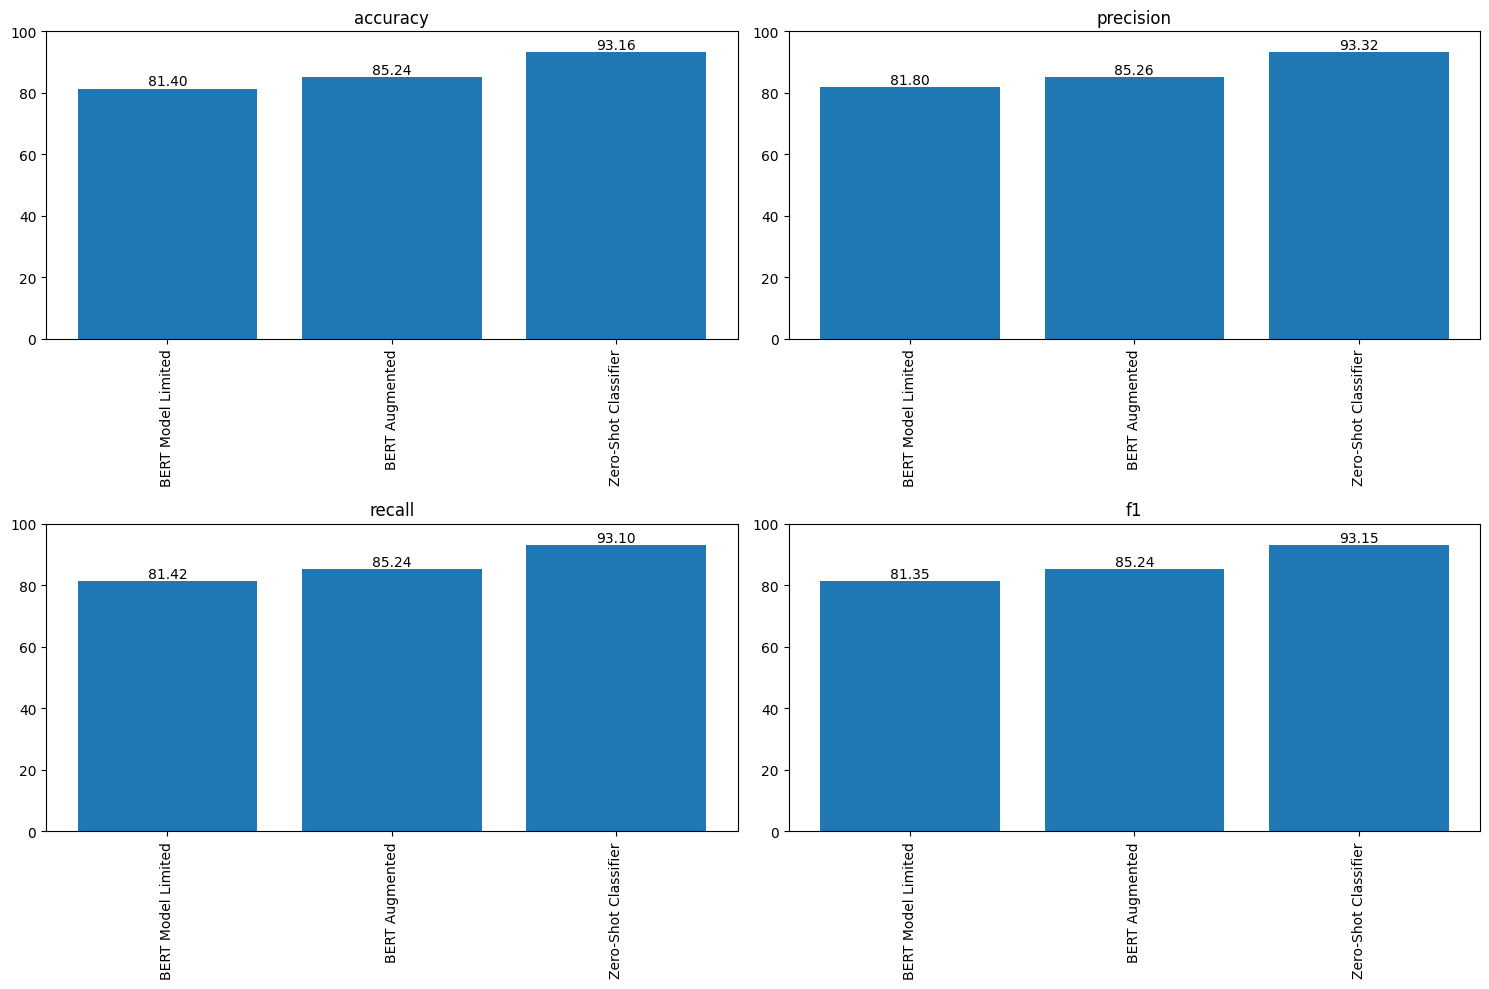

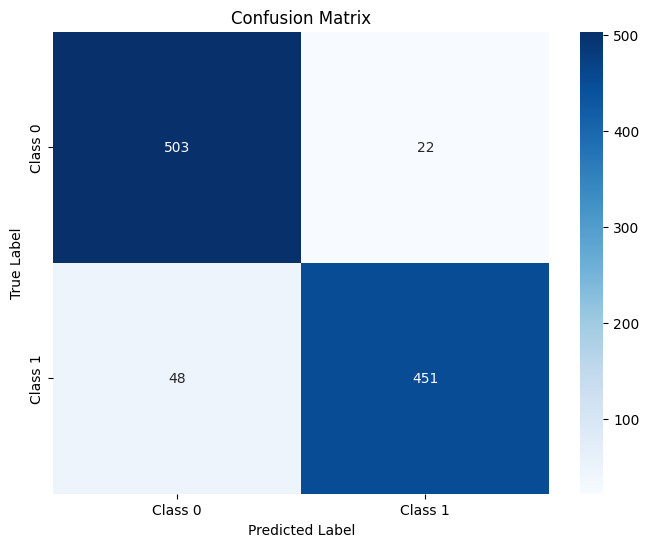

In [ ]:
from transformers import pipeline

df_test_sub = df_test.sample(n=8192, random_state=SEED)

texts = df_test_sub['text'].tolist()
candidate_labels = ["positive", "negative"]

if RUN_WITH_GPU == True:
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)
else:
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

results = classifier(texts, candidate_labels, batch_size=8)

predicted_labels = [result['labels'][0] for result in results]
predictes_scores = [result['scores'][0] for result in results]

test_preds_np = np.array(predicted_labels)

test_preds_zero = np.where(test_preds_np == "positive", 1, 0)

labels_test_sub = df_test_sub['label'].to_numpy().astype('int32')

metrics_test2.run(labels_test_sub, test_preds_zero, "Zero-Shot Classifier")
metrics_test2.plot()

# print_scores(labels_valid_sub, valid_preds)
show_confusion_matrix(labels_test_sub, test_preds_zero)

Right now we realized that when running with the good gpus the model runs much faster than expected so with the 1024 observations it went down from a runtime of 10 minutes to a runtime of 30 seconds. That being said, given how costly it has already been to run everything once with the good gpus and the amount of time that everything else takes to run, we will leave this as it is right now.

Regardless of the amount of observations, this model clearly performs at a higher accuracy than the previous ones from part 2a and 2b.
Even when we are only running 1024 observations of it, it is highly improbable that it would perform this good if in reality it wasn't supposed to perform at 92-93% accuracy with a larger number of observations.
This is extremely weird given that at least those were being fine-tuned a little bit by the 32 labeled examples but this model has seen, theoretically 0 labeled examples from our dataset.

Upon closer examination of the paper that introduced the model that we're using for the zero-shot classification (which you can find in the references section and which we will further discuss below, in 2e), we think that the reason behind these unexpectedly good scores might be the fact that the zero-shot model's training has prepared it extensively for the task at hand and, as such, it performs this task much more like a trained model than like a pure zero-shot classification model. It probably saw some (or quite a lot of) "positive" "negative" classification training data or at least some other data that implied similar contexts. As a result, we have to take these extremely good scores with a pinch of salt.

## DATA GENERATION WITH LLM

We decided to use gpt2 as LLM for this part because gpt4 can only be used through openAI API, which uses API keys and requires we leave those keys here in the notebook if we want it to work on other systems.

As we are not comfortable sharing the personal keys we have from our personal accounts, please understand that we decided to use gpt2 instead, which can be found openly in HuggingFace: https://huggingface.co/openai-community/gpt2

In [ ]:
gpt2 = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(gpt2)
GPT2 = GPT2LMHeadModel.from_pretrained(gpt2)

if RUN_WITH_GPU == True:
    text_generator = pipeline('text-generation', model=GPT2, tokenizer=tokenizer, device=0)  # device=0 for GPU
else:
    text_generator = pipeline('text-generation', model=GPT2, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

We decide to create a total of 128 additional reviews. This amount is in between of creating too few additional reviews so it doesn't add enough information if those reviews are actually useful but not too large to turn the dataset into complete noise if the reviews are not useful.

In [ ]:
max_length = 128
num_seqs = 64

In order to optimize the prompt for GPT2 we went to openAI website and used GPT4 to come up with an optimized prompt to get the best results possible.

The specific prompt we used in GPT4 for the positive reviews prompt was:

"Return a prompt to be used in GPT2. The prompt should give instructions to the model so that it returns a made up customer review for different products found in amazon.com. The review should be for products like books, computers, board games, toys, office supplies, etc. and for a different type of product every time that the prompt is given to the model. The review has to be POSITIVE, meaning that the made up customer who is supposedly writing it LIKES the product."


For the negative reviews the prompt we gave to GPT4 was:

"Return a prompt to be used in GPT2. The prompt should give instructions to the model so that it returns a made up customer review for different products found in amazon.com. The review should be for products like books, computers, board games, toys, office supplies, etc. and for a different type of product every time that the prompt is given to the model. The review has to be NEGATIVE, meaning that the made up customer who is supposedly writing it DOES NOT LIKE the product.
Extend the list of product categories we provided to a lot more possible categories of products sold by Amazon."


We had to edit a little bit both prompts because GPT2 was not being able to handle the lenght of the prompts that GPT4 provided us with, but the adjustments we needed to do were minimal.

In [ ]:
positive_prompt = "Please generate a positive customer review for a randomly selected product from an expanded list of categories, including but not limited to: books, computers, electronics, board games, toys, office supplies, home and kitchen gadgets, sports equipment, fashion items, beauty products, pet supplies, automotive accessories, garden tools, and health and wellness products. The review should come from the perspective of a satisfied customer who has recently bought and experienced the product. Emphasize the particular features or attributes of the product that impressed the customer, such as its durability, innovation, fun factor, or how it satisfies a specific need or enhances their daily life. Make sure the review is thorough and persuasive, detailing how this product distinguishes itself from others on the market or contributes significantly to the customer's lifestyle or productivity. The tone should be positive and authentic, aiming to inspire others to consider buying the product. Each time this prompt is used, randomly select a different category from the list to ensure a diverse array of product reviews."
negative_prompt = "Please generate a negative customer review for a randomly selected product from a wide range of categories, including but not limited to: books, computers, electronics, board games, toys, office supplies, home appliances, fashion and clothing, beauty and personal care, pet supplies, sports and outdoor gear, automotive parts, garden and outdoor equipment, and health and personal wellness items. The review should come from the perspective of a dissatisfied customer who has recently purchased and used the product. Focus on specific aspects or features of the product that did not meet the customer's expectations, such as poor quality, lack of functionality, failure to match the product description, or not providing the promised value. The review should be detailed and critical, explaining why the product falls short compared to alternatives or how it failed to enhance the customer's life or meet their needs. The tone should be straightforward and genuine, with the aim of cautioning others against purchasing the product. Each time this prompt is used, a different product category from the list should be randomly selected to ensure a variety of reviews."

positive_reviews = text_generator(positive_prompt, max_length=max_length+len(tokenizer.encode(positive_prompt)), truncation=True, num_return_sequences=num_seqs)
negative_reviews = text_generator(negative_prompt, max_length=max_length+len(tokenizer.encode(negative_prompt)), truncation=True, num_return_sequences=num_seqs)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
positive_df = pd.DataFrame({'text': [r['generated_text'].split(positive_prompt)[-1].strip() for r in positive_reviews], 'label': 1})
negative_df = pd.DataFrame({'text': [r['generated_text'].split(negative_prompt)[-1].strip() for r in negative_reviews], 'label': 0})

df_train_gen = df_train_limited.copy()

df_train_gen = pd.concat([df_train_gen, positive_df, negative_df]).reset_index(drop=True)

Here we were encountering some runtime issues when not running with the premium gpus so we increased batch size for the training dataset a little bit from 2 to 4. The difference is barely noticeable.

In this case we shuffle like in previous cases, but we find it specially important here because the added reviews might follow a positional pattern otherwise due to how we create them by concatenating strictly differentiated dataframes with the synthetic reviews from GPT2.

In [ ]:
batch_size_train = 4

if LOAD_MODEL == True:
  bert_model3 = load_model(f"{MODEL_LOAD_PATH}/BERT_2d")
elif SAVE_MODEL == True:
  bert_model3 = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)
  bert_model3.summary()

  batch_size_train = 4

  tf_train_gen = tf_dataset_creator(df_train_gen)

  tf_train_gen = tf_train_gen.shuffle(len(df_train_gen)).batch(batch_size_train)

  bert_model3.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

  bert_model3.fit(tf_train_gen, validation_data=tf_valid, epochs=EPOCHS)
  bert_model3.save_weights(f"{MODEL_SAVE_PATH}/BERT_2d")
else:
  bert_model3 = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)
  bert_model3.summary()

  batch_size_train = 4

  tf_train_gen = tf_dataset_creator(df_train_gen)

  tf_train_gen = tf_train_gen.shuffle(len(df_train_gen)).batch(batch_size_train)

  bert_model3.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

  bert_model3.fit(tf_train_gen, validation_data=tf_valid, epochs=EPOCHS)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

In [ ]:
# valid_preds = bert_model3.predict(tf_valid)
# valid_preds = np.round(valid_preds).astype('int32').flatten()

labels_valid = df_valid['label'].to_numpy().astype('int32')

# metrics_val.run(labels_valid, valid_preds, "BERT LLM Gen")
# metrics_val.plot()
# show_confusion_matrix(labels_valid, valid_preds)

625/625 [==============================] - 42s 64ms/step


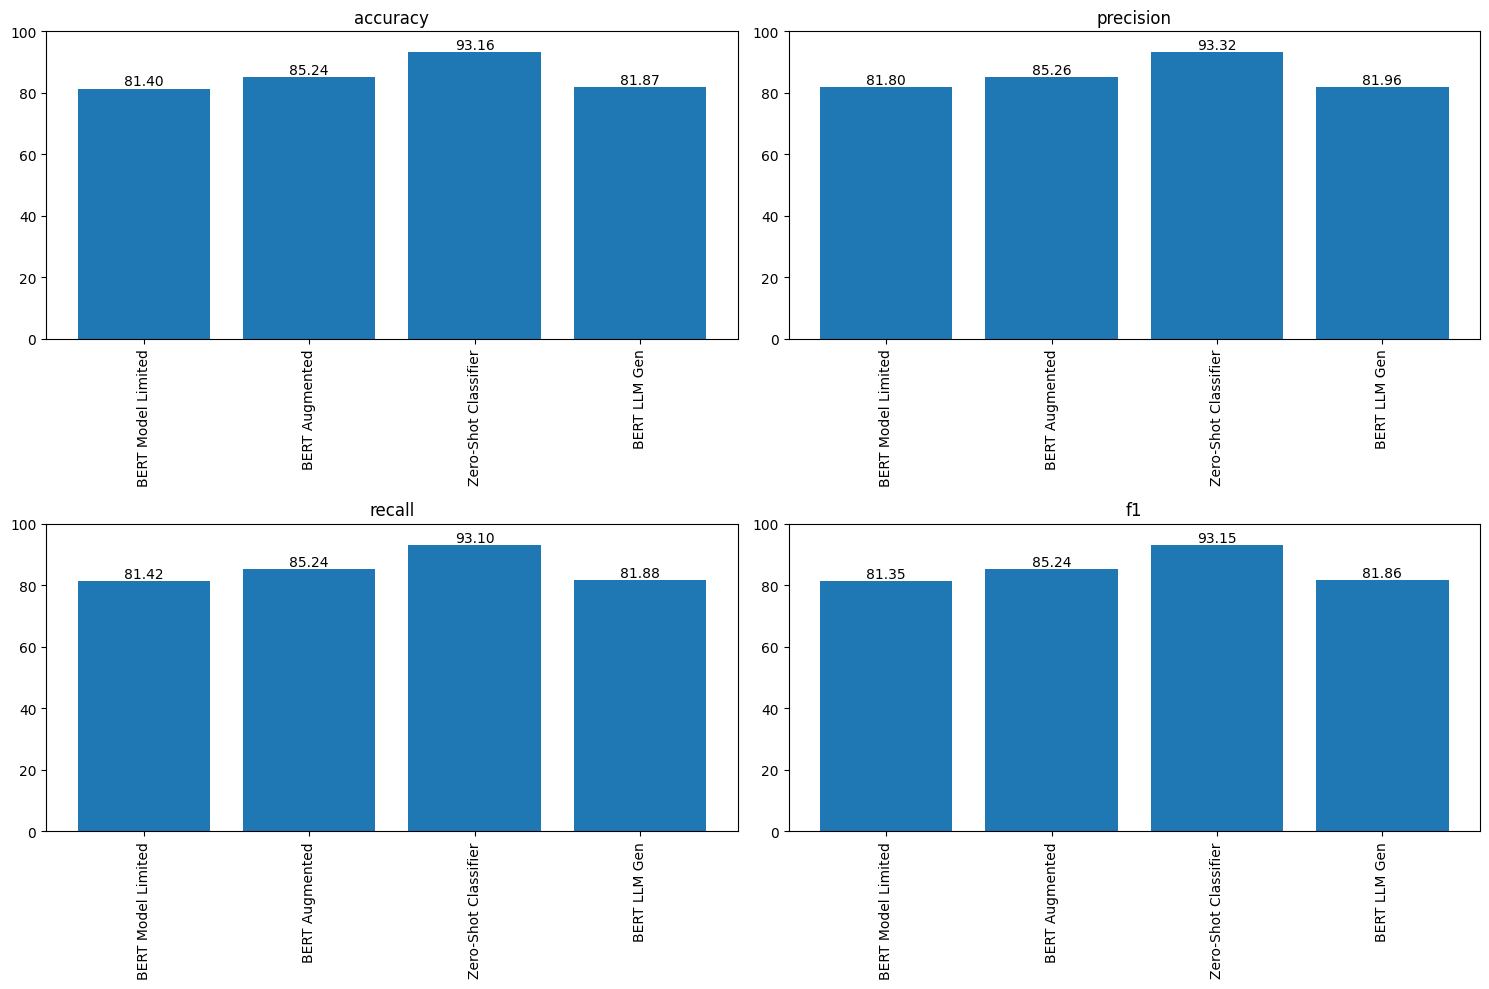

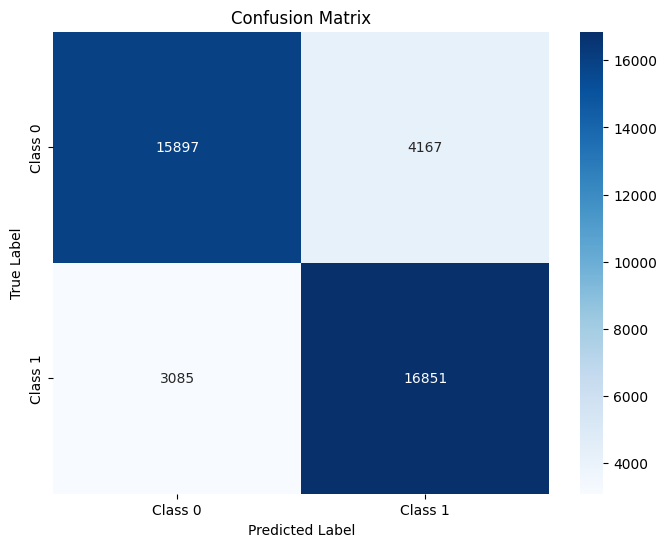

In [ ]:
test_preds = bert_model3.predict(tf_test)
test_preds_gen = np.round(test_preds).astype('int32').flatten()

labels_test = df_test['label'].to_numpy().astype('int32')

metrics_test2.run(labels_test, test_preds_gen, "BERT LLM Gen")
metrics_test2.plot()

# print_scores(labels_test, test_preds_gen)

show_confusion_matrix(labels_test, test_preds_gen)

In this case, the results are not as promising as with the model in part 2b, with the synonym augmentation, but the scores are still an improvement from the basic 32 label model so we can consider the LLM synthetic reviews to at least add some predictive power to the model.

We can observe how the model still has a little bit more difficulty with correctly classifying negative reviews in comparison to positive reviews, but this difference is smaller than in part 2a.

In general we are happy with those results as we were not expecting much from GPT2 after how hard it was to fine-tune the prompts so it would not output complete gibberish. That being said, it appears that after all, the work paid off as we were able to add a little bit of predictive power to the model.
A bit of a cautionary tale here, though, would be that there is still a very high probability that this improvement is due to randomness in the outputs of the model and it can still be that the output of the LLM is not really useful so it's important not to put too much faith in the improvement it can bring forward.

In comparison to the augmentation we did in part 2a, we do have to say that the good aspect of this technique (using LLM to generate synthetic data) is that it is robust to "bad" random seeds and even if the initial 32 labeled examples don't provide useful information to the model, the data generated by the LLM might so there might still be cases in which this is the best performing approach.

## OPTIMAL TECHNIQUE APPLICATION

In spite of the outstanding results from the zero-shot model that we used in part 2c, we have decided to use a model that combines the data augmentation part with and without the use of an LLM. This is due to the fact that the results are actually “too” good in the case of the zero-shot model. Our intuition as to why we got such good results, is that the model we are using had already seen data very similar to our dataset, if not the same.

This intuition comes from reading the paper that introduced the BART model (Lewis, M., Liu, Y., Goyal, N., Ghazvininejad, M., Mohamed, A., Levy, O., Stoyanov, V., & Zettlemoyer, L. (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension. arXiv:1910.13461. https://arxiv.org/abs/1910.13461). Even when we are using BART large MNLI, which is a zero-shot fine-tuned version of the base BART (done by the same people at Facebook AI, though), the base version did train on a lot of contextual analysis. As a result, it is highly probable that the BART large MNLI model has a very easy time identifying data for a classification like “positive” and “negative” because its training achieves good results in contextual analysis far beyond this.

In short, we think that using this model is kind of “cheating” because its training has prepared it extensively for the task at hand and, as such, it would be as using a trained model and not really a pure zero-shot classification task.

As a result, we decided to try to further improve the model we have with only 32 labeled reviews with both the methods in 2b and 2d combined. If we had to choose only one we would obviously choose the data augmentation we performed in 2b. It provides solid results which improve the scores, even it if is by just a bit. In comparison, the model in 2d didn't improve the scores of the model by too much.

We want to try if a combination of both models improves the scores or not. Also we won't be using as many examples of data generated by the LLM, we will only be using 16 reviews of each (pos, neg). After adding these 32 additional reviews to the dataset then we will perform a larger data augmentation than the one we did in part 2b. There we only increased the size of the dataset by 5x. Here we're going to augment it by 20x.

In [ ]:
max_length = 128
num_seqs = 16

In [ ]:
positive_reviews = text_generator(positive_prompt, max_length=max_length+len(tokenizer.encode(positive_prompt)), truncation=True, num_return_sequences=num_seqs)
negative_reviews = text_generator(negative_prompt, max_length=max_length+len(tokenizer.encode(negative_prompt)), truncation=True, num_return_sequences=num_seqs)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
positive_df = pd.DataFrame({'text': [r['generated_text'].split(positive_prompt)[-1].strip() for r in positive_reviews], 'label': 1})
negative_df = pd.DataFrame({'text': [r['generated_text'].split(negative_prompt)[-1].strip() for r in negative_reviews], 'label': 0})

df_train_gen_llm = df_train_limited.copy()

df_train_gen_llm = pd.concat([df_train_gen_llm, positive_df, negative_df]).reset_index(drop=True)

In [ ]:
# additionally apply data augmentation as in 2b
df_train_gen_both = augment_dataset(df_train_gen_llm, aug, num_augmented=20)
df_train_gen_both.head()

display(df_train_gen_both)

,label,text
0,1,The second candela in my Elvis collection. The...
1,1,The second CD in my Elvis ingathering. The sec...
2,1,The second CD in my Elvis collection. The seco...
3,1,The second CD in my Dose collection. The secon...
4,1,The 2d CD in my Elvis collection. The second C...
...,...,...
1275,0,All reviews must be positive or neutral and sh...
1276,0,All reviews moldiness be positive or neutral a...
1277,0,All reviews must be positive or neutral and sh...
1278,0,All reviews must be positive operating theatre...


In [ ]:
bert_model_opt = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)

bert_model_opt.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

Here again it's very important that we shuffle the dataset to avoid having positional patterns that should not really be used.

We go back to batch size train = 2 as well because we want to make sure that the model takes all the information possible into account. We still have a decently small dataset so it's fine to use small batch sizes.

In [ ]:
tf_train_gen_both = tf_dataset_creator(df_train_gen_both)

batch_size_train = 2

tf_train_gen_both = tf_train_gen_both.shuffle(len(df_train_gen_both)).batch(batch_size_train)

bert_model_opt.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

In [ ]:
bert_model_opt.fit(tf_train_gen_both, validation_data=tf_valid, epochs=EPOCHS)

Epoch 1/5
640/640 [==============================] - 102s 130ms/step - loss: 0.0855 - accuracy: 0.9617 - precision_3: 0.9596 - recall_3: 0.9641 - auc_3: 0.9947 - val_loss: 1.1501 - val_accuracy: 0.7980 - val_precision_3: 0.7681 - val_recall_3: 0.8523 - val_auc_3: 0.8487
Epoch 2/5
640/640 [==============================] - 72s 113ms/step - loss: 0.0196 - accuracy: 0.9937 - precision_3: 0.9922 - recall_3: 0.9953 - auc_3: 0.9998 - val_loss: 1.5579 - val_accuracy: 0.7874 - val_precision_3: 0.7609 - val_recall_3: 0.8365 - val_auc_3: 0.8225
Epoch 3/5
640/640 [==============================] - 72s 112ms/step - loss: 6.5647e-05 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - auc_3: 1.0000 - val_loss: 1.8018 - val_accuracy: 0.7803 - val_precision_3: 0.7432 - val_recall_3: 0.8551 - val_auc_3: 0.8106
Epoch 4/5
640/640 [==============================] - 72s 113ms/step - loss: 2.2375e-05 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - auc_3: 1.0000 - val_loss: 1.8012 - v

625/625 [==============================] - 42s 64ms/step


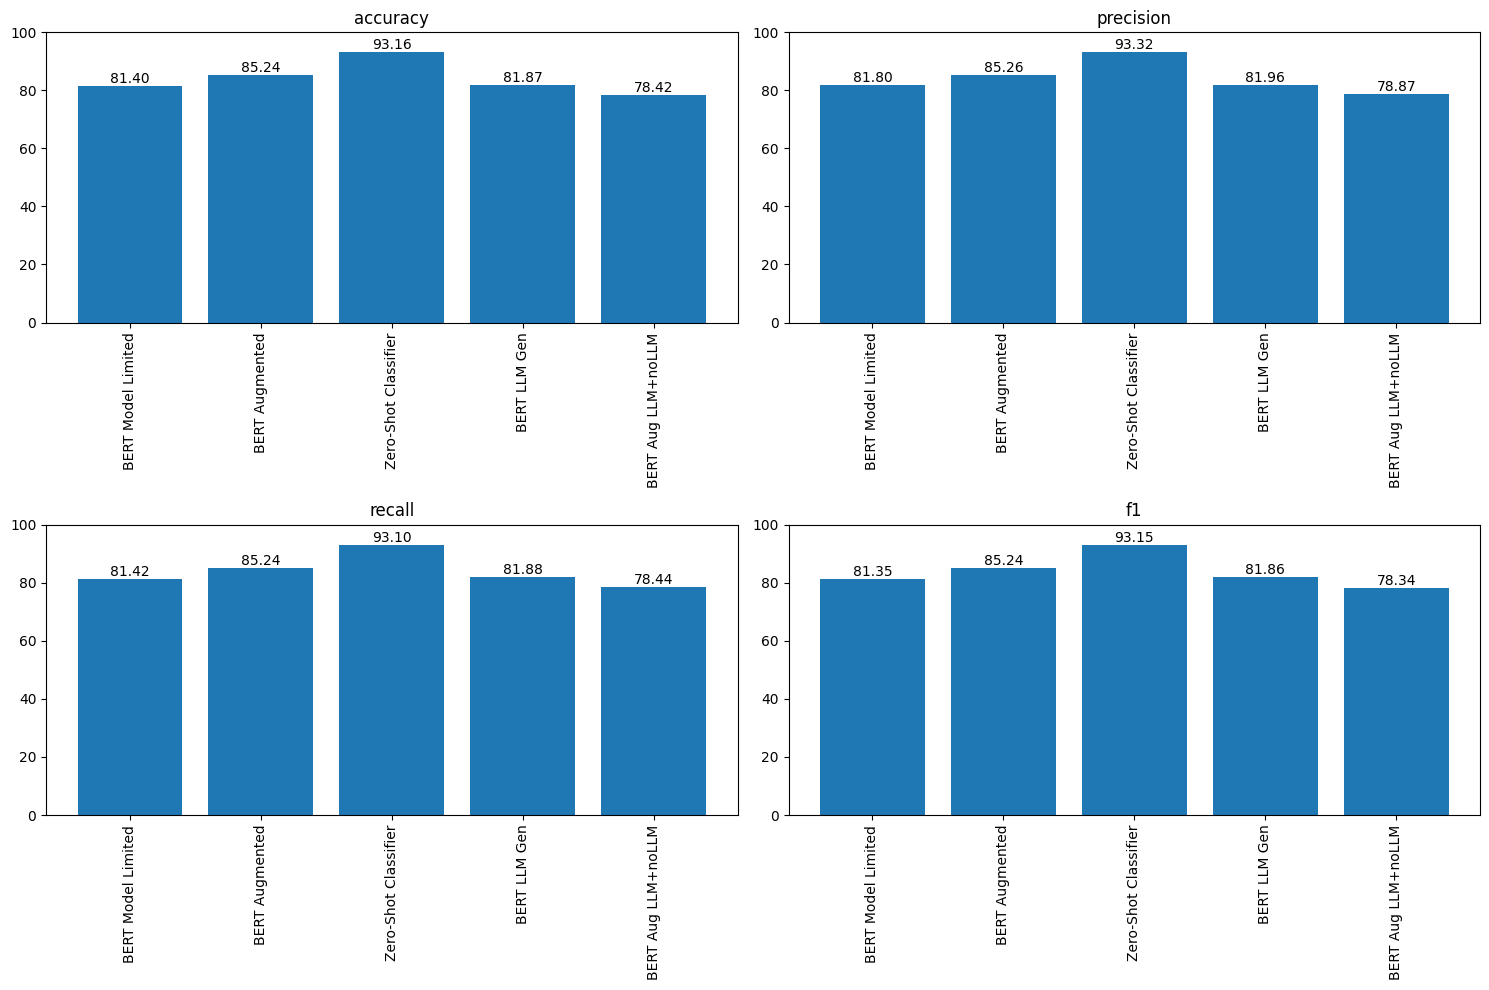

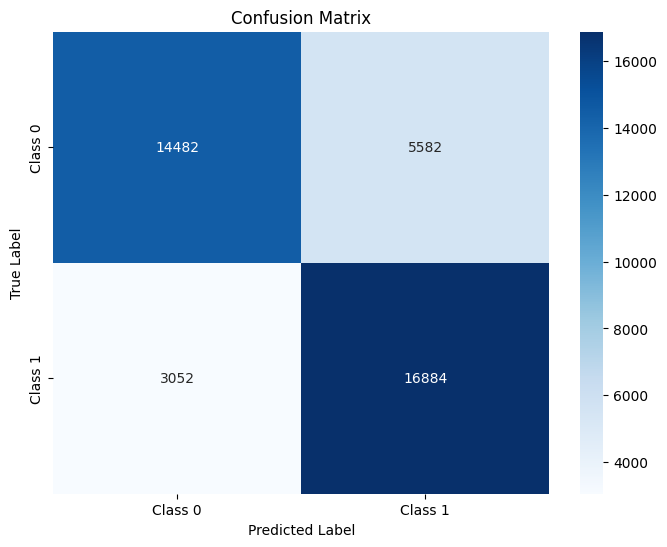

In [ ]:
test_preds = bert_model_opt.predict(tf_test)
test_preds_gen_both = np.round(test_preds).astype('int32').flatten()

labels_test = df_test['label'].to_numpy().astype('int32')

metrics_test.run(labels_test, test_preds_gen_both, "BERT Aug LLM+noLLM")

metrics_test2.run(labels_test, test_preds_gen_both, "BERT Aug LLM+noLLM")
metrics_test2.plot()

show_confusion_matrix(labels_test, test_preds_gen_both)

We can clearly see that the model performs very badly as it even goes below the level of the basic 32 examples model. We can even see that the false negatives are nearly the same amount we had in the previous part (2d), which suggests that the decrease in scores comes mainly from the model being less capable of classifying the negative reviews correctly. This could be due to the fact that this time the LLM generated very poor examples for the negative reviews which led to the model receiving mainly noise.

Please do notice that we put this model in 2e into the metrics_test object because previously to running this last run we really thought that this model could perform better. Maybe we could have avoided this issue by running the model on 16 reviews already generated by the LLM in part 2d, as apparently those were a little bit better than the ones we got this time. But it can also be that the synthetic reviews generated by the LLM are just too noisy so when we augment them 20 times the model starts to have a really hard time discerning the signal from the noise. In previous runs this approach really yielded us some decent results, but then those runs were performed with a different percentage for the subsampling. This can vary two variables, even with the same random seed:
- The 32 selected labeled examples can be different because the sampling of the 32 was performed on a smaller dataset. As a result in previous runs we might have had an initial set of 32 labeled examples of lower quality. This is also supported by the fact that in some runs the results we got from the agumentation in 2b (which this time were outstanding) were not too promising and barely improved on the model in 2a (we must notice that on those runs the augmentation in 2b was still the best performing if we excluded the zero-shot results, but in then the improvement with respect to the LLM augmentation was very tiny). This change clearly affects how the synonym augmenter performs as well.
- Even with the random state being determined in everything we can, the LLM model has some parameters that make sure it outputs different responses every time it encounters the exact same prompt. This can be tuned so that the model performs in a more "predictable" way but we thought that it was not necessary to tune those before this last run.

In conclusion, we can say that the best performing model in this section was, without a doubt, the zero-shot-learning model, although it might be "cheating" in some way.

Next comes the model with agumentation in 2b, although in some runs where the data from the 32 labeled examples was very bad, this last model actually performed slightly better (again, the difference in those cases was much smaller than the difference we have seen in this last run).

The not so good model is the LLM augmented model, which in some good runs like this one (we say good because in total terms, the scores are generally better than in some other runs) performs poorly and can even lead to results which underperform from the model in 2a when implemented together with the augmentation with synonyms from 2b.

The model from 2a with only the 32 labeled examples tends to be toward the lower end of the scores from this part 2 so we can safely say that the dataset augmentation techniques we have applied seem to work out fine most of the time. The main problem we encounter for this part is that, when working with so little amount of labeled examples, our model's scores can vary immensely from one set of 32 examples to another one.

Most of the times, even with the huge variability associated to this part, data augmentation with synonyms has proven to be able to improve the scores of the model from 2a even if it meant only improving accuracy by a 0.5%.

That being said, we also must recognize that GPT4 would probably bring much better results for part 2d and would probably perform in a very stable way, much like the zero shot model from 2c, which got 92-93% accuracy in nearly all the runs we took.

# PART 3: STATE OF THE ART COMPARISON

## FULL DATASET TRAINING

In this case we do not set the model to be loaded in this specific step because with the iteration involved it would be very problematic. It is crucial here to get the "history" object, from the run, which we are not able to load from the .keras files so we just need to run this every time.

Also please notice that for runtime limitations we were force to lower the number of epochs per fitting to 1 for this part because fitting 5 epochs to 100% of our data would have taken hours of runtime (which we don't have).

We initialize a new Metrics class object in order to be able to graph all the scores consecutively for these increasing percentages fittings.

The rest of the fit follows the same structure that we have been using in part 2, but with the change that now we have bigger training datasets to take into account.

We also keep trainable = True as in part 2 because we still want our distilBERT model to be fine-tuned specifically to our dataset.

625/625 [==============================] - 42s 64ms/step
Results for 1.0% of the data:
Test Set:


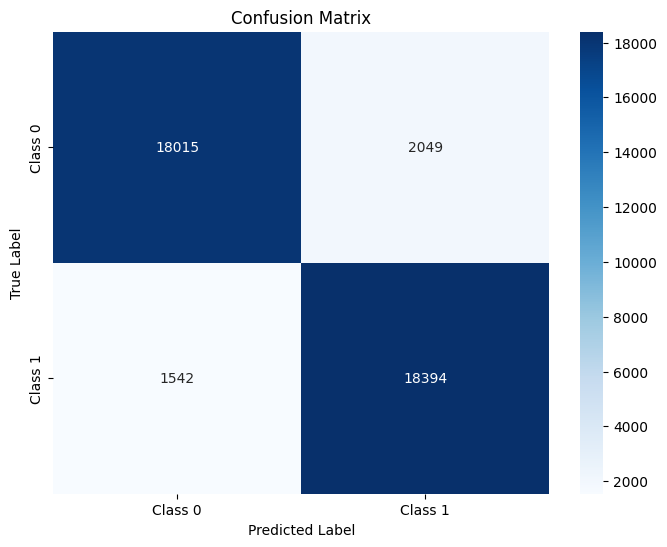

################################################## 


625/625 [==============================] - 42s 65ms/step
Results for 10.0% of the data:
Test Set:


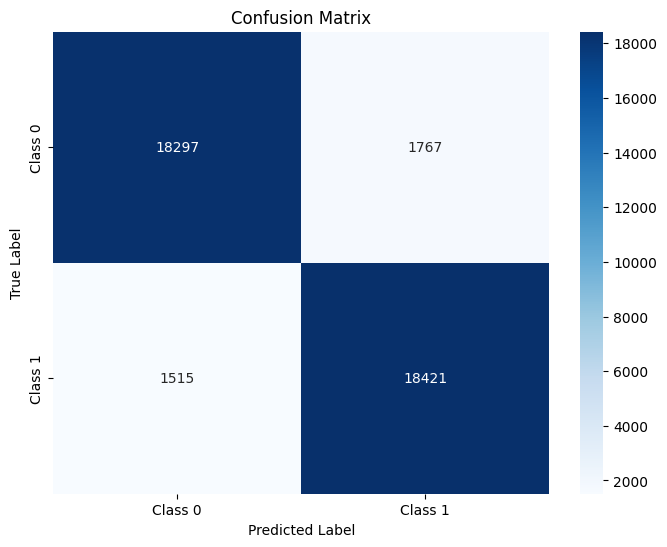

################################################## 


625/625 [==============================] - 42s 64ms/step
Results for 25.0% of the data:
Test Set:


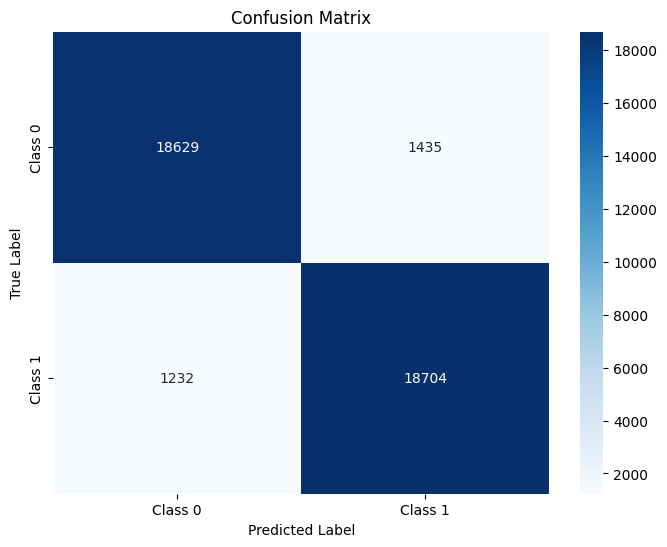

################################################## 


625/625 [==============================] - 42s 65ms/step
Results for 50.0% of the data:
Test Set:


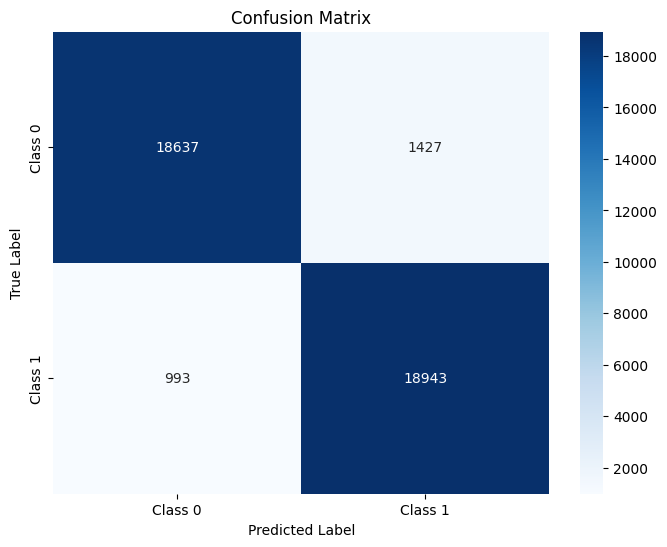

################################################## 


625/625 [==============================] - 42s 64ms/step
Results for 75.0% of the data:
Test Set:


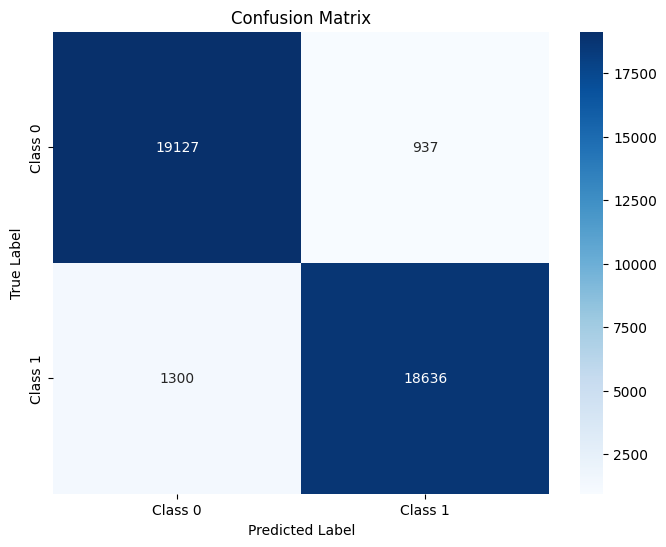

################################################## 


625/625 [==============================] - 42s 64ms/step
Results for 100.0% of the data:
Test Set:


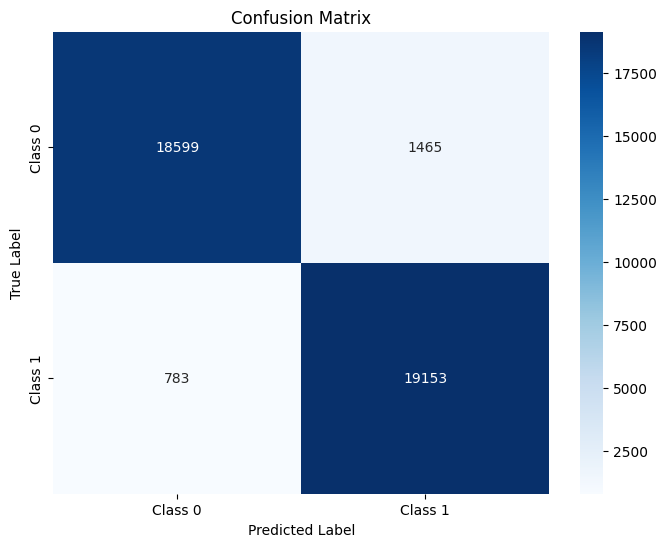

################################################## 




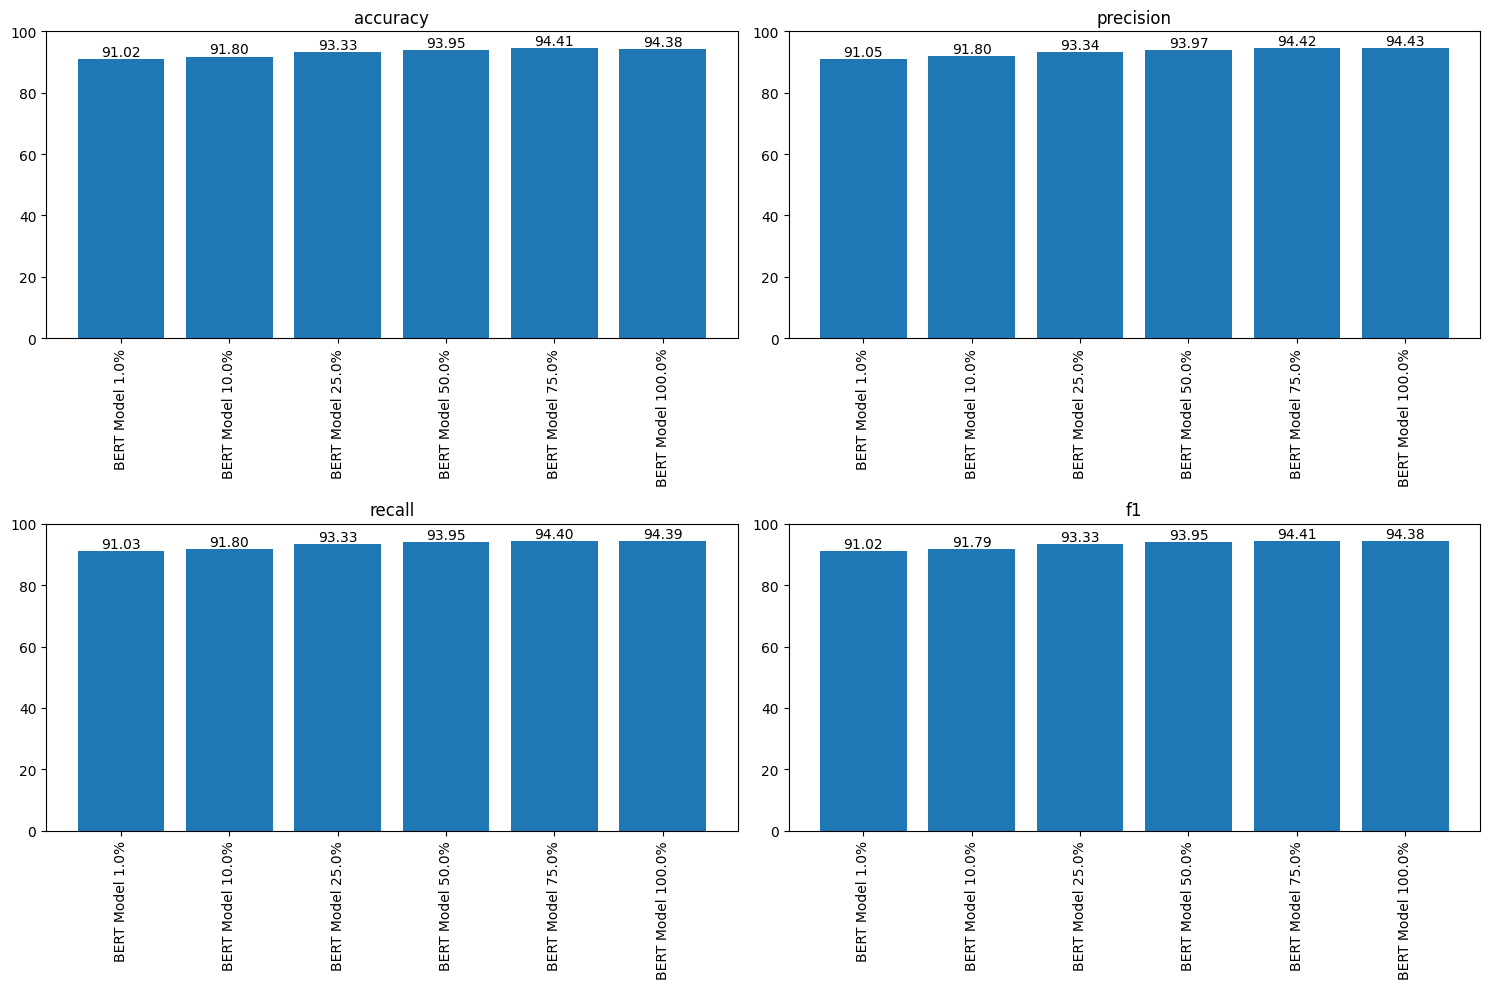

In [ ]:
metrics_test3 = Metrics()
labels_valid = df_valid['label'].to_numpy().astype('int32')
labels_test = df_test['label'].to_numpy().astype('int32')

# Define a function to train model with the different percentages of data
def train_model_with_percentage(data_percentage):
    num_samples = int(len(df_train) * data_percentage)
    tf_train_percentage = tf_train.take(num_samples)

    # In this case we set trainable=False because we might be facing potentially very large datasets
    # and with trainable=True our model might end up over-fitting a little bit.
    # Also having trainable activated might send the runtime up to some levels we cannot afford.
    model_full = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)

    # We set up a pretty high batch size as well because, again, our dataset ends up being very large.
    batch_size_train = 128

    # In this case we don't use the .shuffle method because the size of the dataset is potentially
    # too large when using percentages above 25% of the whole dataset. Additionally, the data doesn't
    # seem to follow any particular order so shuffling in other parts was more of a profilactic measure
    # rather than a strict necessity.
    tf_train_percentage = tf_train_percentage.batch(batch_size_train)

    model_full.compile(optimizer=Adam(learning_rate=5e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy', Precision(), Recall(), AUC()])

    # Train model
    history = model_full.fit(tf_train_percentage, validation_data=tf_valid, epochs=1)
    model_full.save_weights(f"{MODEL_SAVE_PATH}/BERT_3a_{data_percentage*100}")

    # Predict on validation set
    test_preds = model_full.predict(tf_test)
    test_preds = np.round(test_preds).astype('int32').flatten()

    # Store in the metrics class we created for validation in this part:
    metrics_test3.run(labels_test, test_preds, f"BERT Model {data_percentage*100}%")
    print(f"Results for {data_percentage*100}% of the data:")
    print("Test Set:")
    show_confusion_matrix(labels_test, test_preds)

    # Store test accuracy and save model for 100% to metrics_test
    test_accuracy = accuracy_score(labels_test, test_preds)
    print(f"#"*50, "\n\n")

    # We set an if clause so the last model, with 100% of the data, gets stored in the metrics_test object.
    if data_percentage == 1.0:
      metrics_test.run(labels_test, test_preds, f"BERT Model {data_percentage*100}%")

    return history.history['accuracy'], history.history['val_accuracy'], test_accuracy, test_preds, model_full

# Define percentages
percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]

# Train models with different percentages of data
train_accuracies = []
val_accuracies = []
test_accuracies = []
test_preds_dict = {}

for percentage in percentages:
    train_accuracy, val_accuracy, test_accuracy_temp, test_preds_temp, bert_model_full = train_model_with_percentage(percentage)
    train_accuracies.append(train_accuracy[-1])
    val_accuracies.append(val_accuracy[-1])
    test_accuracies.append(test_accuracy_temp)
    test_preds_dict[f"{percentage*100}%"] = test_preds_temp

metrics_test3.plot()

It is important to notice that we saved the model with 100% of the data to the general metrics_test object because in other runs it had performed slightly better than the 75% model. In this case, though, it has not been like this. It is highly probable that with 3 or 5 epochs (or even more) the model with 100% of the data would have been able to perform better than the model with 75% of the data but still, even as it is right now, the results are really good.

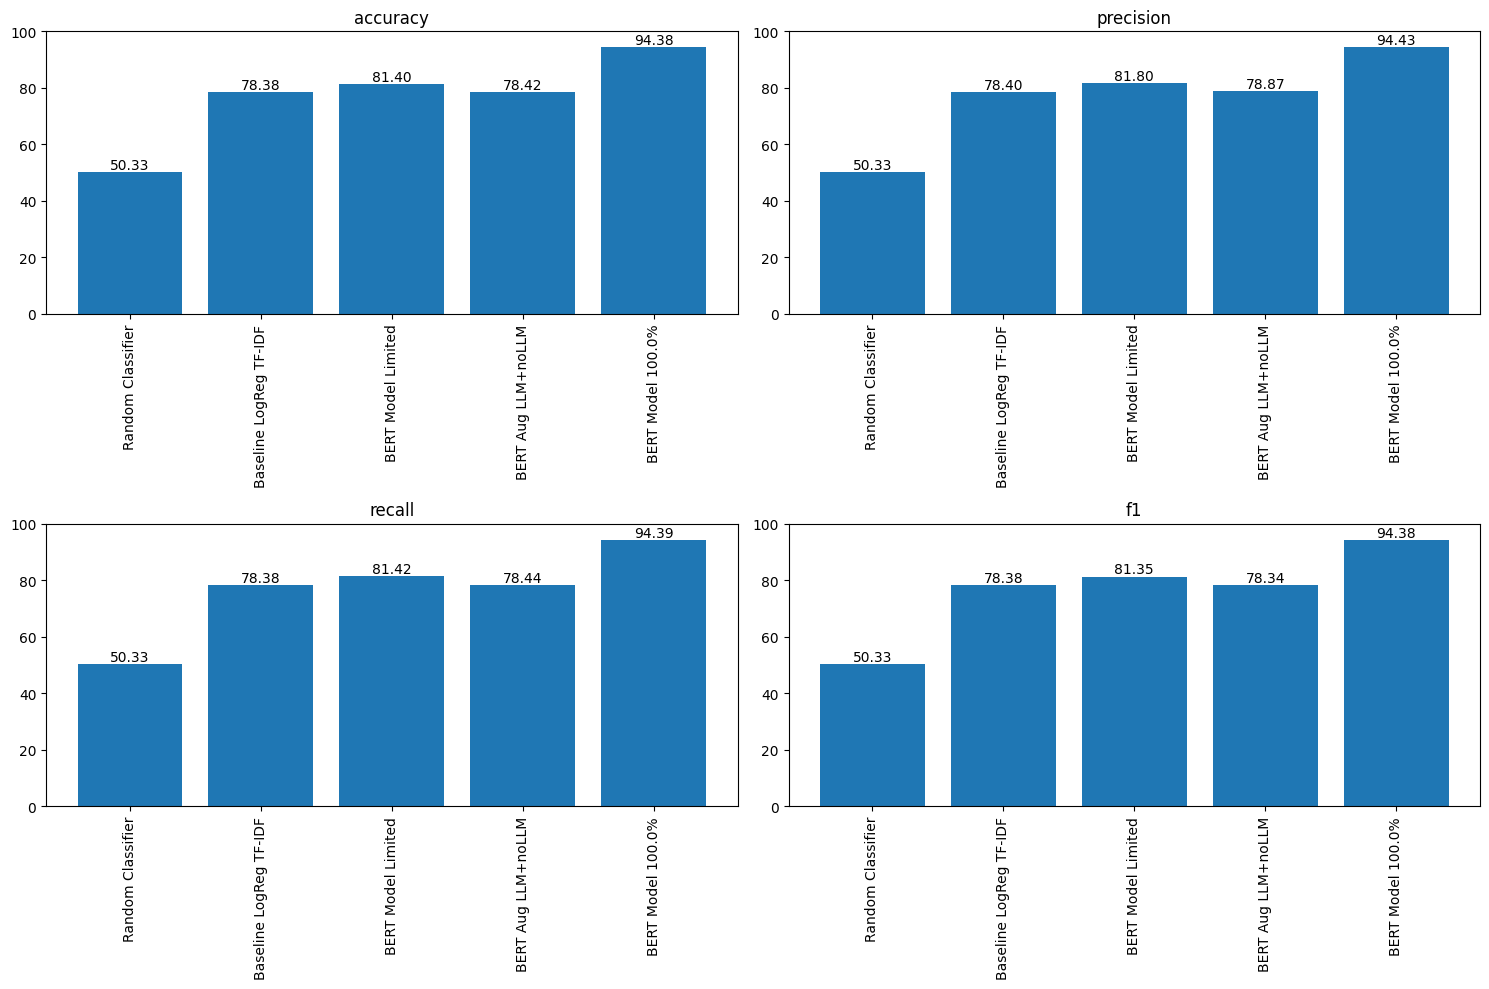

In [ ]:
metrics_test.plot()

Here we can also see the enormous improvement to the model only by letting it train with fine-tuning to a bigger amount of labeled examples of the dataset.

## LEARNING CURVE

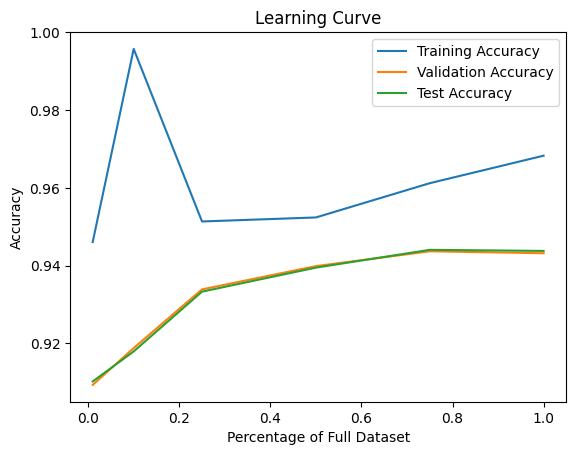

In [ ]:
# Plot learning curve
plt.plot(percentages, train_accuracies, label='Training Accuracy')
plt.plot(percentages, val_accuracies, label='Validation Accuracy')
plt.plot(percentages, test_accuracies, label='Test Accuracy')
plt.xlabel('Percentage of Full Dataset')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


With regards to the learning curve, we must notice that the training accuracy is not necessarily the best metric to take into account.

Instead, we should focus on the validation and test curves, which move nearly in the same manner, increasing in accuracy as the percentage increases. We are very happy with those results.

Also it must be noticed that the scale on the y axis here gets adjusted automatically, which leads to the scale taking only from 0.9 to 1.0 accuracy on the ordinates axis. This adjustment helps with noticing the increase on the accuracy of our model but it takes away the information about how good our accuracy scores really are. It means that none of the models we trained in part 3a got an accuracy score of less than 90% on the validation nor on the test sets.

## TECHNIQUE COMPARISON

Since it yielded better results in Part 2, let's apply data augmentation without using an LLM now with the full dataset available. In this case, however, we are going to use 25% of our full training set due to its large size and we are only going to augment it to 2x of its size. As a result, we are going to end up with a dataset which has a size similar to that of 50% of our training dataset (ergo, 5% of the entire amazon polarity dataset). This means that our end training augmented dataset for this part has approximately 150k labeled reviews, with half of them being synonym augmented versions of the other half.

We want to see if the increase in scores from the data augmentation can be significant enough to compensate for actual labeled data.

If this model performs as well as the model in 3a with 50% of the whole data, then we will be able to conclude that our data augmentation from part 2b is actually a very good technique to be used when there isn't enough quality labeled data.

In [ ]:
# Define the percentage of the full dataset to use
data_percentage = 0.25

# Sample 25% of the training dataset
num_samples = int(len(df_train) * data_percentage)
df_train_25_percent = df_train.sample(frac=data_percentage, random_state=SEED)

aug = naw.SynonymAug(aug_src='wordnet')

df_train_25_percent_augmented = augment_dataset(df_train_25_percent, aug, num_augmented=2)

# tf_train_25_percent_augmented = tf_dataset_creator(df_train_25_percent_augmented)


For the reasoning behind the batch size for the training dataset and the max length please refer to the explanations provided *supra* for both of them.

In this case we also had to train the model only for 1 epoch for the same reasons as in part 3a, the model was potentially going to run for too much time if trained on more epochs.

In [ ]:
batch_size_train = 128
max_length = 128

if LOAD_MODEL == True:
  bert_model4 = load_model(f"{MODEL_LOAD_PATH}/BERT_3c")
elif SAVE_MODEL == True:
  bert_model4 = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)
  bert_model4.summary()

  batch_size_train = 128
  max_length = 128

  tf_train_25_percent_augmented = tf_dataset_creator(df_train_25_percent_augmented)

  tf_train_25_percent_augmented = tf_train_25_percent_augmented.shuffle(len(df_train_25_percent_augmented)).batch(batch_size_train)

  bert_model4.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

  bert_model4.fit(tf_train_25_percent_augmented, validation_data=tf_valid, epochs=1)
  bert_model4.save_weights(f"{MODEL_SAVE_PATH}/BERT_3c")
else:
  bert_model4 = get_BERT_model(distilBERT, 0.5, max_length, trainable=True)
  bert_model4.summary()

  batch_size_train = 128
  max_length = 128

  tf_train_25_percent_augmented = tf_dataset_creator(df_train_25_percent_augmented)

  tf_train_25_percent_augmented = tf_train_25_percent_augmented.shuffle(len(df_train_25_percent_augmented)).batch(batch_size_train)

  bert_model4.compile(optimizer=Adam(learning_rate=5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

  bert_model4.fit(tf_train_25_percent_augmented, validation_data=tf_valid, epochs=1)

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                    

625/625 [==============================] - 42s 65ms/step


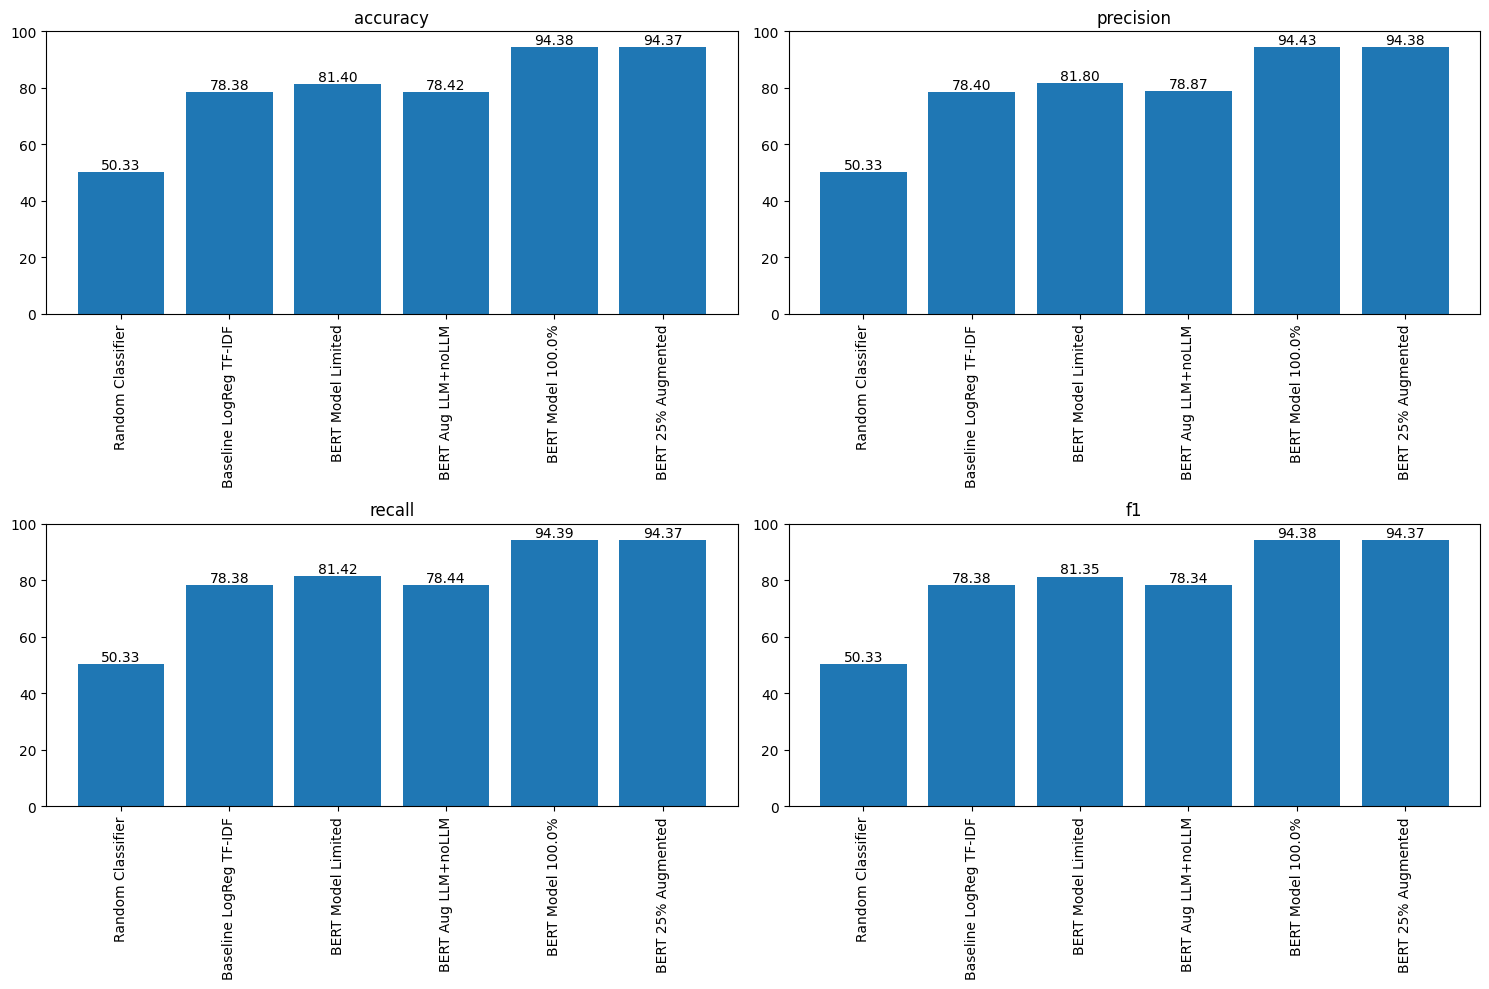

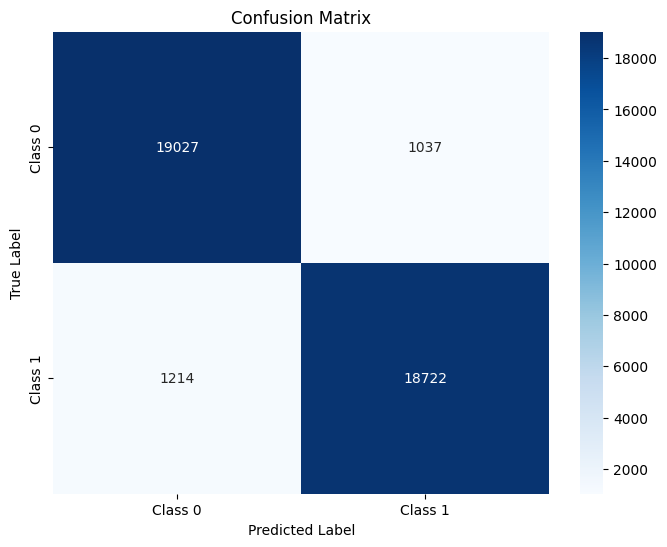

In [ ]:
test_preds_aug = bert_model4.predict(tf_test)
test_preds_aug = np.round(test_preds_aug).astype('int32').flatten()

labels_test = df_test['label'].to_numpy().astype('int32')

metrics_test.run(labels_test, test_preds_aug, "BERT 25% Augmented")
metrics_test.plot()
show_confusion_matrix(labels_test, test_preds_aug)

The results in this section are actually outstanding. This last model performs approximately as well as the model with 100% of the training dataset, which means *de facto* that it performs even better than its namesake model in 3a (with 50% of the training dataset). We might not jump to infer that this model definitely will always perform better than the model with the real labeled examples but what we can determine for sure is that the synonym augmentation technique is a very solid approach if the labeled examples in the base training dataset are of high quality and provide good contextual information for the model to learn.

In this case, due to only augmenting the dataset to twice its size, it was able to still maintain a very good diversity with the data. It probably is the case that synonym augmentation is a very good technique for maybe duplicating or triplicating the size of a training dataset but that when it comes to more than that the results can tend to have too high variability and stop being reliably improved. In 2b we saw a very significant improvement, but in previous runs we had also seen not so great improvements. On the other hand, here it is more improbable that this improvement is due to the variability of selecting one 25% subset as opposed to a different 25% subset mainly because those subsets are so big (near 80k reviews) that they should contain a similar share of "quality reviews" to that of the whole dataset.

In conclusion, duplicating the dataset using synonym augmentation has proved to be a very solid method which can reliably improve scores when used to increase the size of a dataset which contains quality labeled examples.

## METHODOLOGY ANALYSIS

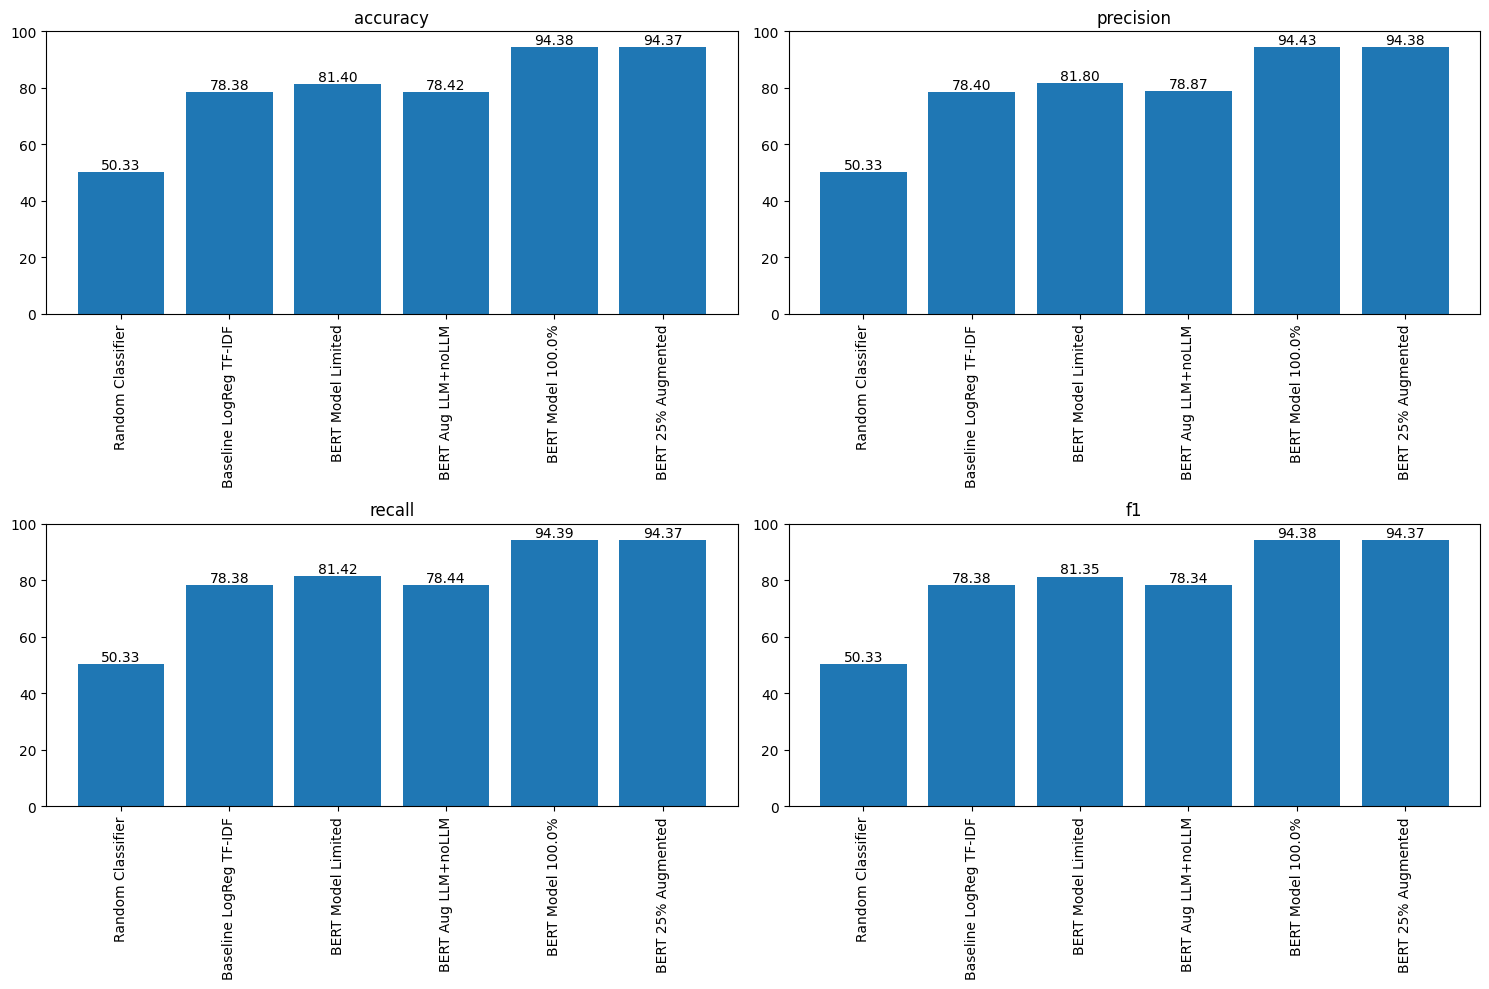

In [ ]:
metrics_test.plot()

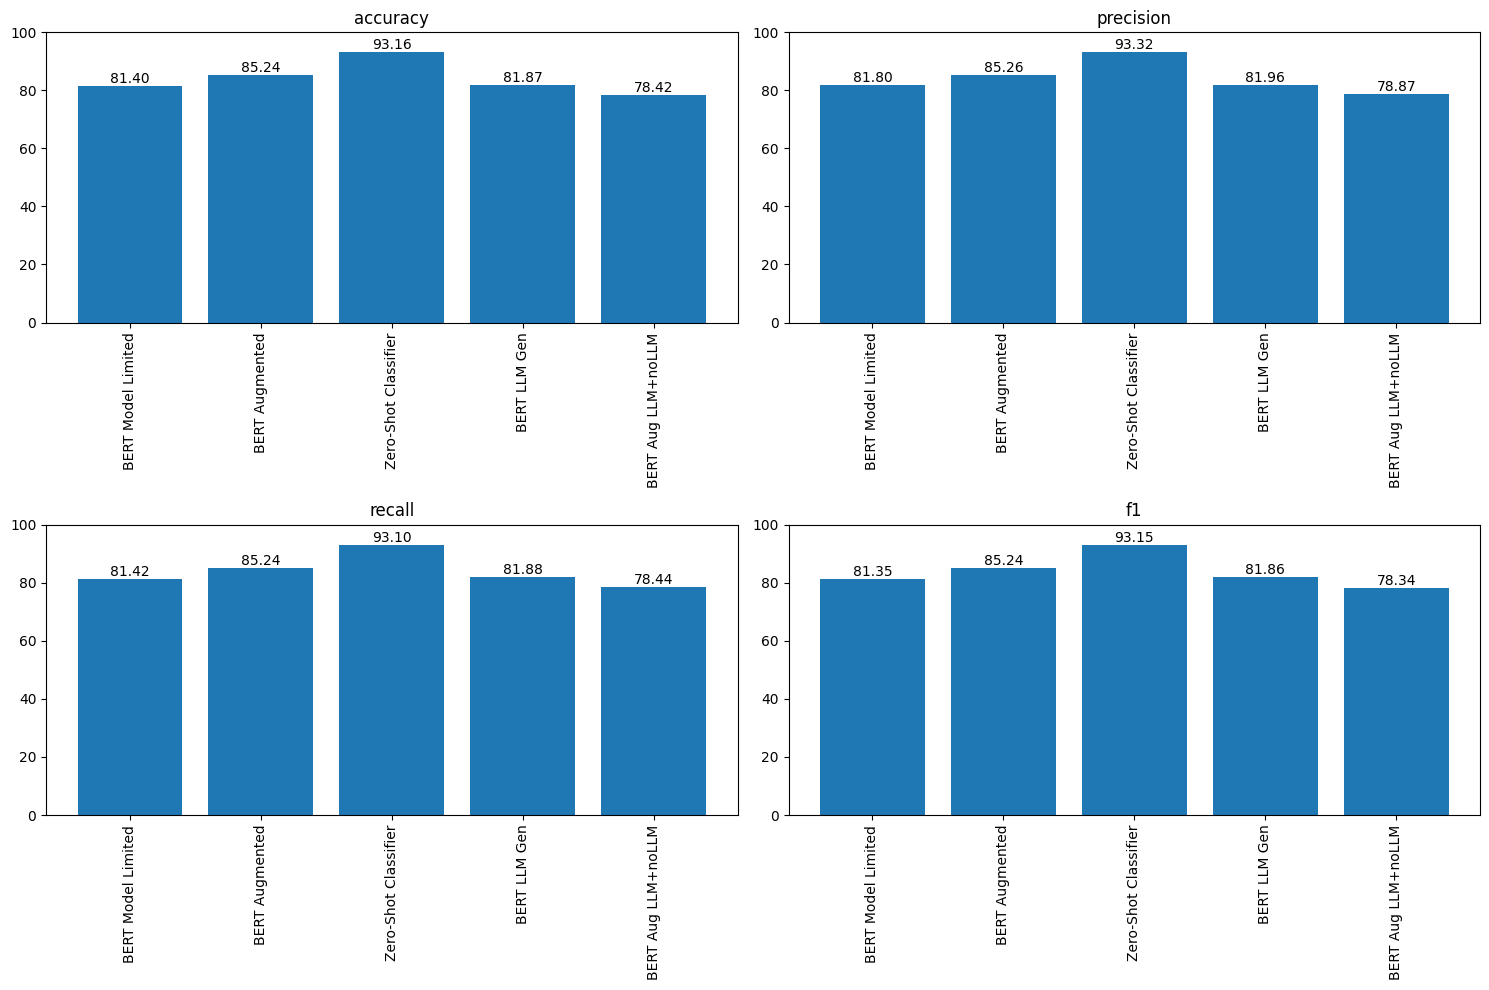

In [ ]:
metrics_test2.plot()

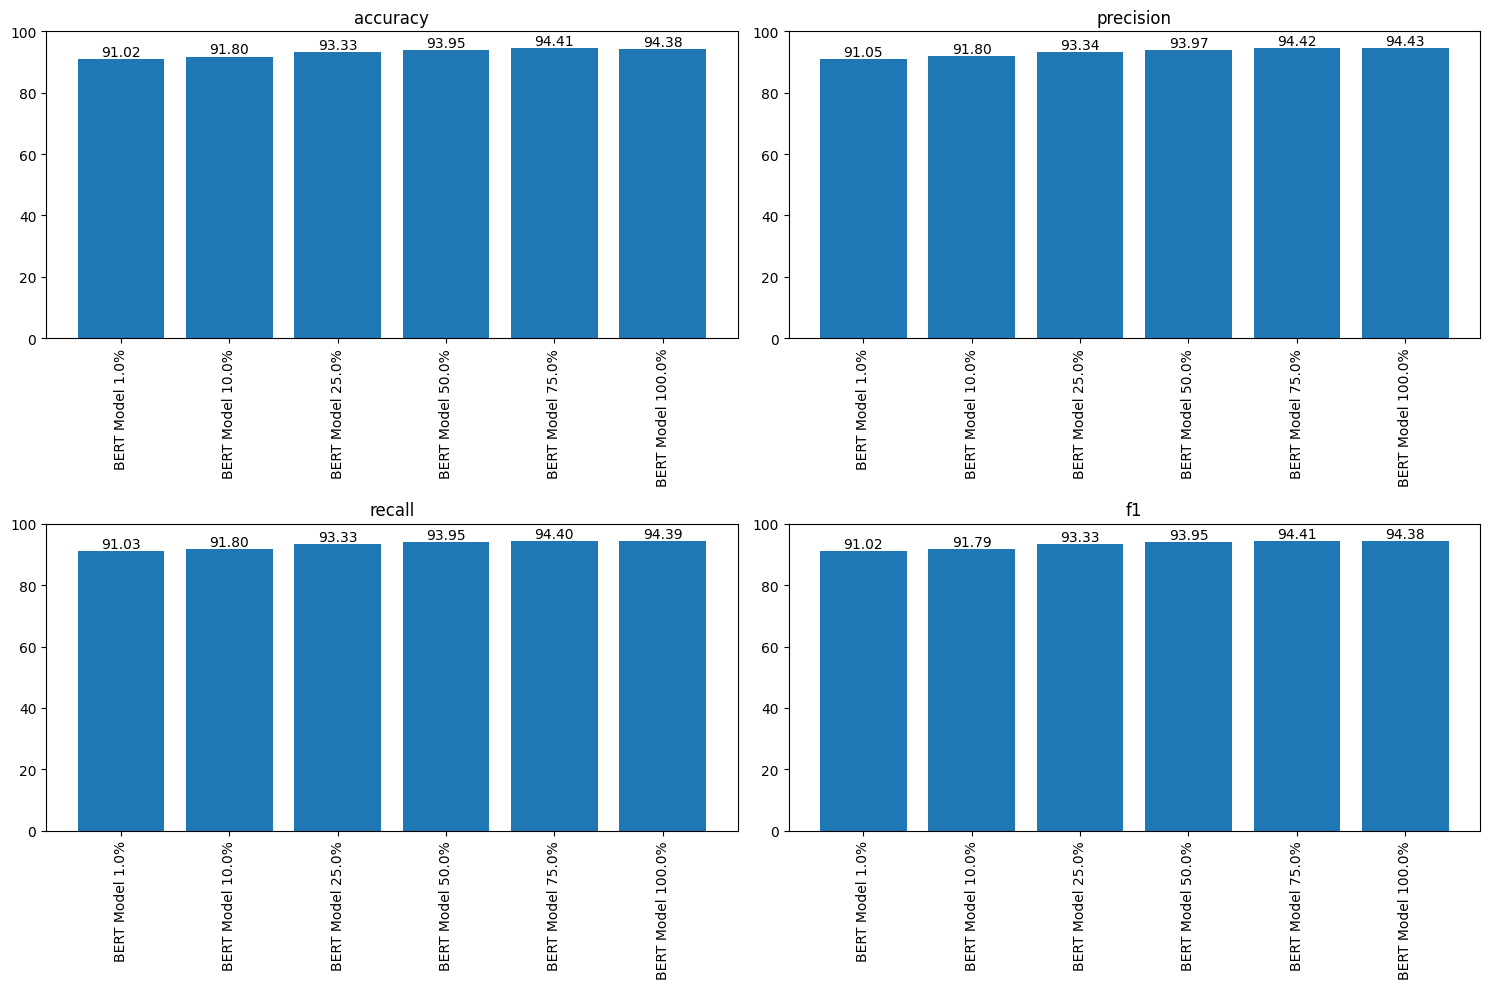

In [ ]:
metrics_test3.plot()

Taking into account that the state of the art sits at slightly more than 97% accuracy on this type of classification problem, we are within 3% of it with our last 2 models from part 3a, which is a very good result and even more if we compare it with the baseline model we set up earlier. We also must take into account that our model took not too long to be trained (when compared to a model that can be used to perform at the SOA) and it was fine-tuned to only 10% of the training dataset. Just by increasing the number of epochs and the subsample percentage we could surely already improve it further, which is really good news and comes to show that our model is very decent.

In general, in this part we saw how using a bigger amount of quality labeled examples is key in order to improve the performance of the model as all the datasets we got in this part performed at an accuracy higher than 90%. Compared to the models in part 2, where none of the models there reached 90% or even got close to it (with the exception of the zero-shot classifier, which we don't count as a normal example of part 2), the improvement of using more than just 32 labeled examples is very noticeable and highly relevant.

That being said, we also saw that some of the techniques we employed in part 2 are really robust and specifically synonym agumentation can be applied to larger datasets to get the scores to really good standards very quickly. It would probably be very interesting to study the "ROI" of this type of agumentation to see how it improves the model's scores as the size of the labeled examples dataset increases. Also it would be important to study it's variability. We already saw how the improvement on the version in 2a, where we only had 32 labeled examples was potentially of a 5% accuracy improvement (maybe even more) but it also had a potential pitfall when those 32 labeled examples were not the best pos/neg examples. Regarding the model in the part 3c, we saw how the potential improvement in the accuracy scores was much lower (around 1%) but also it was much more robust to changing the specific dataset to which it was applied as the dataset with 25% of the data will not vary in its quality as much as the 32 examples dataset.

Another matter which we still haven't commented on is how important fine-tuning the model can get to be in those cases. We saw in previous works how there could be the case where fine-tuning did not make the biggest difference on the scores of the model at hand, but here we were able to experiment how much of a difference it can make when the dataset is big enough and of quality high enough. We did run the notebook once with fine-tuning set to false and the results were disastrous. The model in part 2a was performing worse than the random classifier, none of the other models in part 2 were even nearing the vicinities of the scores of the basseline logistic regression model (with the exception, again, of the zero-shot classifier, which still performed at 92-93% because it is not affected by whether we fine-tune or not) and, more importantly, the models here in part 3 performed at accuracy scores lower than 85%, which means that in these cases the addition of fine-tuning to the distilBERT model led to an improvement of near a 10% in the scores for part 3, with much higher improvements for the models in part 2 except in part 2c.
In short, we really experimented how fine-tuning can be essential when trying to approach the SOA point of more than 97% accuracy on positive/negative sentiment analysis of reviews.

Nevertheless, we are quite sure that the improvement from our 94.4% accuracy to the 97.4% accuracy of the SOA might need a lot more work than the improvement we just got from 0 to 94.4% as we would need to work on:
- Using the full dataset.
- Also training on other datasets to improve model performance even further.
- Training for way more epochs so the fine-tuning could perform at its full potential.
- Improving the model itself so that it incorporates a higher capacity to analyze contextual information and it can then do a better job on fine-tuning the weight of the underlying BERT-like model.
- Using the BERT large model instead of the distilBERT, which would kick the runtimes even further away.
- And potentially even other aspects that we are not able to think about because we also lack the knowledge just to take them into account and then control for them in the model.

All in all, the journey to the SOA still has a lot of steps before us but we can be sure that for now we have covered a good part of it. As Pareto stated, most of the results come from a small part of the efforts and, for us, with our efforts so far we got pretty far away already. If I had to bet my money on a probability of 94%, the odds would still be hugely in favor of me. The difference between 97% and 94% on the odds, for example, could matter at a very high level, but in general, 94% would already be very favorable odds.

# PART 4: MODEL DISTILLATION

## MODEL DISTILLATION

Knowledge distillation, introduced by (Hinton et al., 2015) [Read the paper](https://arxiv.org/pdf/1503.02531.pdf) is a model size reduction technique aiming at reducing computational expenses and obtaining more sustainable LLMs. It basically consists on training a lighter model (student model) that should learn from a bigger model (teacher model) and the objective is to find similar metrics as those of a teacher model but with a considerable improved time of execution.

There are different ways in which a student model can learn from the teacher model. It can learn from the logits produced in the output layer (final predicted probabilities), it can learn from the weights or activations of intermediate/hidden layers, and it can also learn from the relationship between differen types of activations across input, hidden and output layer.

In supervised learning, as it is our case, one of the most usual techniques to do knowledge distillation is the response-based knowledge -learning from the final output predictions-  the one used by the student model.

As the teacher model (cumbersome model), the student model will be trained with a loss function that penalizes differences between the student model predictions and the true labels (a usual binary crossentropy loss). However, it will also incorporate another loss function -called distillation loss- that penalizes for differences between final predictions of the student model versus those of the teacher model. The weighted average of these two losses form the total loss on which the model is trained.

Using the distillation loss during trainning of the student model will make the student model better at making close predictions to those the teacher model does being a lighter model. We follow by describing the followed steps.

In our case, we have used the pre-trained DistilBert Model as a base model to perform all previous exercises. Our best-performing model are both models trained on the 75% and 100% of the data in exercise 3a. We will use as a "teacher model" the model trained on the 100% as it is the last one that has been trained and saved.
As a student model, we will load the pre-trained TinyBert model version from HuggingFace (prajjwal1/bert-tiny) https://huggingface.co/prajjwal1/bert-tiny publicly made available by *Prajjwal Bhargava and Aleksandr Drozd and Anna Rogers (2021)* as a result of their paper *Well-Read Students Learn Better: On the Importance of Pre-training Compact Models*. This model results of Knowledge distillation from a BERT model.

Just by printing out the configuration of these two pre-trained models (distilbert and tinyBert) we can already see that that TinyBert is a lighter model. The number of hidden layers, size of hidden layers and attention heads for TinyBert is 2, 128 and 2 while the same parameters for DistilBERT are 6, 768 and 12.

To get our student model, we load the pre-trained tiny-bert model and as done for the teacher model, we add input layer for input ids and attention masks, with same max length (128). In this case, the model will use the TFBertForSequenceClassification which will directly output the logits given the inputs. Then, we add a dropout layer with a 0.5 rate, same as the one used in the teacher model and finally, the dense layer is passed.

In [ ]:
#Load TinyBert from HuggingFace
tokenizer_tiny = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
tinybert_model = AutoModel.from_pretrained("prajjwal1/bert-tiny")

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

In [ ]:
def get_student_model(pretrained_model_name, num_labels, max_length, dropout_rate):
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    # Load the PyTorch model weights and automatically convert them to TensorFlow
    bert_model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels, from_pt=True)

    # Define the input layers
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name='attention_mask')

    # Get the outputs of bert_model, ensuring compatibility with TensorFlow
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract the logits from the outputs
    logits = outputs.logits

    # Add dropout layer for regularization
    dropout = tf.keras.layers.Dropout(dropout_rate)(logits)

    # Define the output layer based on binary task
    output = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(dropout)

    # Construct the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model, tokenizer

# Configuration
pretrained_model_name = "prajjwal1/bert-tiny"
num_labels = 1  # 1 for binary classes
max_length = 128
dropout_rate = 0.5

# Load the model and tokenizer
student_model, tokenizer_tiny = get_student_model(pretrained_model_name, num_labels, max_length, dropout_rate)

# Summarize the model
student_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   4386049   ['input_ids[0][0]',           
 ification (TFBertForSequen  (loss=None, logits=(None,               'attention_mask[0][0]']      
 ceClassification)           1),                                                           

If we check the model summary from the teacher model (Part 2a) we observe that it has a total number of parameters (all trainable) of 663.636.649 and a size on disk of 253.16MB while the student model summary reveals fewer trainable parameters 4.386.051 and a significant smaller size on disk (16.73MB).

Once we have our student model, we have created a class in which we incorporate all methods that will be needed to compile and fit the model, as well as to make predictions. The main point is found in the training step.

In thi step, first of all, the batch of data received is unpacked. Then, the self_teacher attribute is accessed to produce predictions on the same data.

Right after this, there are a series of steps taken withing the tf.GradientTape, a context manager of TensorFlow that records operations of automatic differentiation.  In this case, it will calculate the gradients of the total_loss function with respect to the trainable variables (weights and biases) of the student model. The calculated gradients will be applied to the trainable variables of the student model using the optimizer (self.optimizer.apply_gradients()). This step updates the model parameters to minimize the total loss. To get to this total loss, the following steps are followed.

First, the logits of the student model are computed, followed by the task-loss (loss derived from deviations of student model predictions and true labels). After this, the logits from both the teacher and student models are softened using softmax division by a temperature parameter (self.temperature). This softmax operation converts the raw logits into probabilities.

Afterwards, the distillation loss is computed. This loss is computed with the tensorflow object tf.keras.losses.KLDivergence which replicates the Kullback-Leibler Divergence measure, which is measuring how one probability diverges from a second expected probability. In this case, the difference between teacher and student model probability distribution. The final total_loss function is computed giving a weight (self.alpha) to the task loss and the distillation loss.

In the class, we also introduce the methods to perform testing, calling the model to do predictions and compute metrics.

In [ ]:
class DistilBertStudent(tf.keras.Model):
    def __init__(self, student_model, teacher_model, temperature=2.0, alpha=0.5):
        super(DistilBertStudent, self).__init__()
        self.student_model = student_model
        self.teacher_model = teacher_model
        self.temperature = temperature
        self.alpha = alpha
        self.distillation_loss_fn = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.AUTO)
        self.task_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def compile(self, optimizer, metrics):
        super(DistilBertStudent, self).compile()
        self.optimizer = optimizer
        self.metrics_tracker = metrics

    def train_step(self, data):
        # Unpack the data.

        if isinstance(data, tuple):
            x, y_true = data
        else:
            x, y_true = data[0], data[1]

        # Generate teacher logits dynamically with no gradient tracking
        teacher_logits = self.teacher_model(x, training=False)

        with tf.GradientTape() as tape:
            student_logits = self.student_model(x, training=True)

            # Calculate the task-specific (hard target) loss
            task_loss = self.task_loss_fn(y_true, student_logits)

            # Soften teacher/student logits and calculate the distillation (soft target) loss
            teacher_probs = tf.nn.softmax(teacher_logits / self.temperature, axis=-1)
            student_probs = tf.nn.softmax(student_logits / self.temperature, axis=-1)
            distillation_loss = self.distillation_loss_fn(teacher_probs, student_probs)

            # Calculate the combined total loss
            total_loss = (self.alpha * task_loss) + ((1 - self.alpha) * distillation_loss)

        gradients = tape.gradient(total_loss, self.student_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student_model.trainable_variables))

        # Update metrics
        self.metrics_tracker.update_state(y_true, tf.nn.sigmoid(student_logits))
        return {"loss": total_loss, "accuracy": self.metrics_tracker.result()}

    def test_step(self, data):
        x, y_true = data
        student_logits = self.student_model(x, training=False)
        loss = self.task_loss_fn(y_true, student_logits)

        # Update metrics
        self.metrics_tracker.update_state(y_true, tf.nn.sigmoid(student_logits))
        return {"loss": loss, "accuracy": self.metrics_tracker.result()}

    def call(self, inputs, training=False):
        # Forward pass through the student model
        student_logits = self.student_model(inputs, training=training)
        return student_logits

We follow by instantiating the class with chosen parameters for temperature and alpha being 10 and 0.8. Note that for computationally expenses reasons, we could not run the final part with all data more than once, therefore, the chosen parameters were some parameters that seemed to work well when we tried knowledge distillation with a subsample of the training data of 5000 data points. This will be explained in potential improvements (part 4.3). Finally, we define the metrics and optimizer, we call the compile method, we fit the model and make predictions.

In [ ]:
#Rename the bert_model trained with 100% of data in exercise 3a.
teacher_model=bert_model_full

In [ ]:
#Initialize the Student Model with chosen parameters temperature and alpha.
custom_student_model=DistilBertStudent(student_model=student_model, teacher_model=teacher_model, temperature=10.0, alpha=0.8)

In [ ]:
#Instantaniate compile method by defining first the optimizer and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
metrics = tf.keras.metrics.BinaryAccuracy()
custom_student_model.compile(optimizer=optimizer, metrics=metrics)

In [ ]:
#Batch training data in the same batch size as done in teacher model
batch_size_train=128
tf_train=tf_train.batch(batch_size_train)

In [ ]:
#Fit the student model
history = custom_student_model.fit(tf_train, validation_data=tf_valid, epochs=EPOCHS)

Epoch 1/5
2391/2391 [==============================] - 367s 149ms/step - loss: 0.5175 - accuracy: 0.5009 - val_loss: 0.5483 - val_accuracy: 0.4988
Epoch 2/5
2391/2391 [==============================] - 315s 132ms/step - loss: 0.5098 - accuracy: 0.5009 - val_loss: 0.5306 - val_accuracy: 0.4988
Epoch 3/5
2391/2391 [==============================] - 315s 132ms/step - loss: 0.5072 - accuracy: 0.5009 - val_loss: 0.5259 - val_accuracy: 0.4988
Epoch 4/5
2391/2391 [==============================] - 315s 132ms/step - loss: 0.5050 - accuracy: 0.5009 - val_loss: 0.5320 - val_accuracy: 0.4988
Epoch 5/5
2391/2391 [==============================] - 315s 132ms/step - loss: 0.5034 - accuracy: 0.5009 - val_loss: 0.5312 - val_accuracy: 0.4988


In [ ]:
#Make predictions with the student model
predictions_test=custom_student_model.predict(tf_test)
predictions_test = (predictions_test > 0.5).astype(np.int32)

625/625 [==============================] - 4s 6ms/step


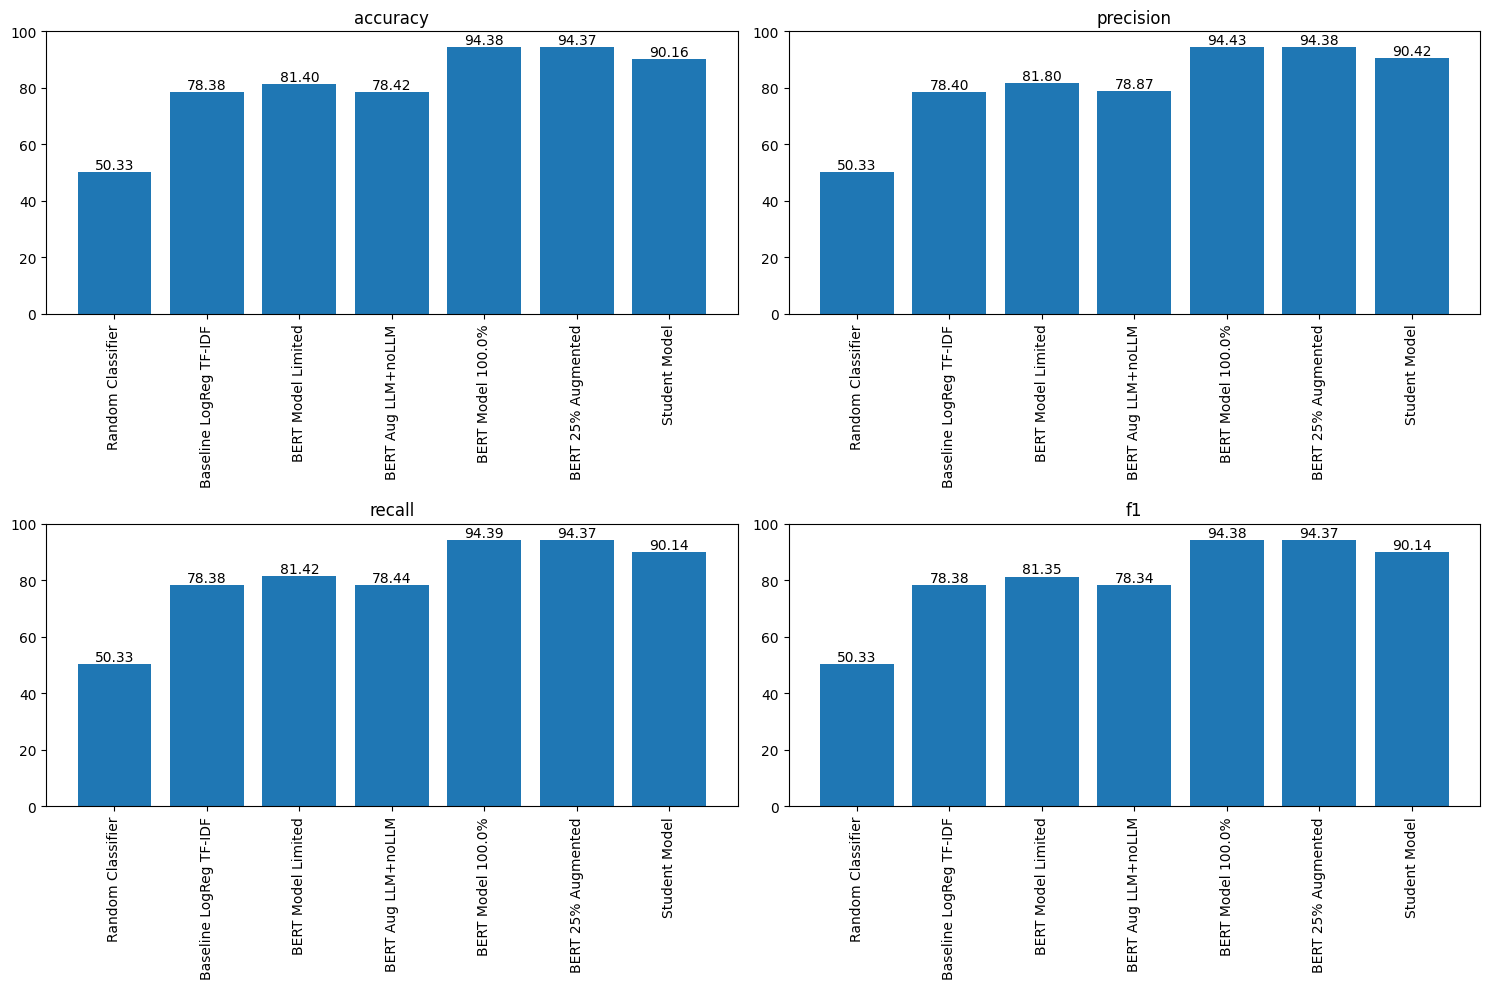

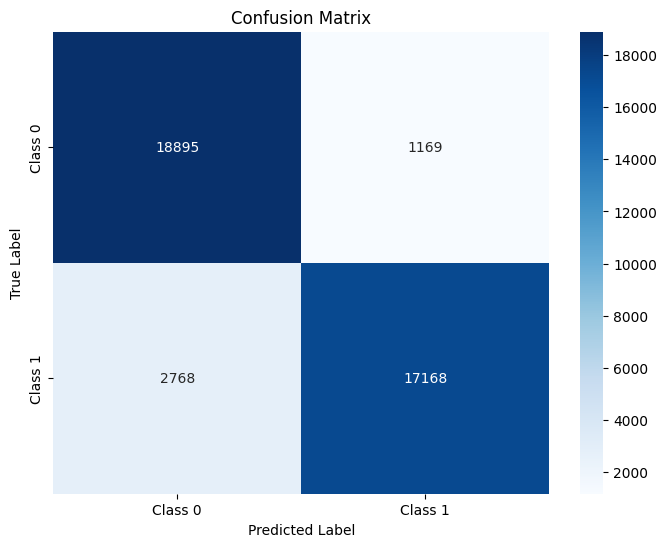

In [ ]:
#Save and plot metrics
metrics_test.run(labels_test, predictions_test, "Student Model")
metrics_test.plot()
show_confusion_matrix(labels_test, predictions_test)

## PERFORMANCE AND SPEED COMPARISON

For efficiency reasons, the teacher model in 3a has been fitted only on one epoch. Given that we are fitting it with quite 306.000 observations, the variability of metrics across epochs was minimal so we left it with one epoch. This epoch lasted 923 seconds with 378ms per step.

The student model has been run on 5 epochs given that as inferred from our subsample analysis, it needed more epochs to considerably learn from the teacher mode. In the final run, it ran on an average of 325,4 seconds per epoch and on an average of 135,4 ms per step. Thus, clearly, we can see that the student model runs almost 3 times faster than the teacher model on an epoch-basis.

Regarding metrics, we see that overall, while the teacher model trained on a 100% of the data (306.000 datapoints) reaches around 94% of all metrics accuracy, precision, recall and f1, the student model reaches a 90% in all these metrics.

More specifically, we see that interestingly while the teacher model has a false negative rate of 783/40.000 (1,96%) and a false positive rate of 1465/40.000 (3,67%), the student model has a false negative rate of 2768/40000 (6,9%) and a false positive rate of 1169/40000 (2,92%).

Thus, we see how the student model performs worse at detecting true positives and better in detecting true negatives while for the teacher is the other way around. But not only in relative terms, but also in absolute terms, the student model, even performing worse in general terms, it has an absolute lower number of false positives than the teacher (1169 vs 1465 false positives). We will comment about these key findings in part 4.3, linked to further improvements.

Considering that the student model runs approximately 3 times faster, it has 16,5 times less parameters and it is 15 times less weighty in terms of MB, we consider that overall, the metrics achieved by the student model are quite decent.

## ANALYSIS AND IMPROVEMENTS

As highlighted in part 4.2, even if the student model has reached outstanding metrics, we have observed that the model is performing, in relative terms, in a different way than the teacher mode. It works worse than the teacher model at detecting true positives while it works relatively and absolutely better at detecting true negatives. There are many factors that could be leading to this outcome.

First of all, the student and the teacher model are based on two different pre-trained models, and it could be the case that those models are already better at detecting either positives or negatives. It could also be the case that each model has inherently bias towards one of each of the classes that could be derived on how these two models have been trained and on which data. Moreover, we have seen that the student model has lighter structure so it could be less able to capture some more complex patterns that in this dataset could be more present in positive reviews, and thus make it increase the false negative rate. At the same time, we see how it detects better true negatives. Thus, it could be that this very often pattern case of reviews where something good precedes the final bad feeling of the user, its better captured by the student model.  A good way to identify these would be fitting the student model on its own, with a normal binary crossentropy loss function on the training data and just one epoch (like in 3a), so that we could compare base performances of the student and teacher model.

Beyond the inherent differences of these two models -given their own structure and pre-trained methods and data-, the parameters temperature and alpha that have been chosen to 10 and 0.8 in the student model fitting could also play a significant role in student model performance’s.
The temperature parameter is used to smooth the probability distribution that is outputted from the SoftMax layer on the logits. Applying it to both student and teacher logits eases the transfer of knowledge from the teacher to the student. If it is set to 1, the probability distribution will be very similar to the raw logits. On the other hand, higher values of T act as a softener, making the probabilities more uniform and smoother while values of T under 1 make probability distribution to be concentrated around maximums.

It is worthy to mention that temperature in binary class classification does not play such a big role as it would do in a multiclass problem given that the objective of the temperature is to communicate to the student model a less extreme probability distribution (as a usual Softmax layer would output) but to inform also about relative probability of less-likely classes. Therefore, in a binary classification task, the process might not leverage the power of this parameter as in a multiclass. In binary classification tasks, it should be the case that lower temperatures would work better not to make the distribution of probabilities so smooth that makes the student model to have difficulties to distinguish classes. Similarly to temperature, the other parameter that could be tuned is alpha, the weight given to the task loss versus the distillation loss. For instance, giving more weight to the task loss makes the predictions of the student model to be more dominant in the final decision-making process than those of the teacher model.

In our case, for computational expense reasons, we could not run the final model with all the data trying different parameters, so we chose the ones that seemed to work well when we were trying knowledge distillation in a subsample of only 5000 datapoints of training data. In these trials, the parameters of 10 for temperature and 0.8 for alpha seemed to work well so those are the ones that were chosen for the final run.

Further improvements would be directed to determine how these parameters are changing the performance and decision-making process of the student and specifically examining the type of deficiencies (false positives and false negatives) that the model would make in each case. Intuitively, we would try to fit the model with a lower temperature term and lower alpha to give more weight to the teacher model knowledge.  

Beyond this, we could further explore other methods of knowledge distillation, for example, in our case, multi-teacher distillation. For example, in the work by  *You, S., Xu, C., Xu, C., & Tao, D. (2017, August). Learning from multiple teacher networks. In Proceedings of the 23rd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1285-1294).*[Read the paper](https://www.researchgate.net/profile/Shan_You2/publication/318918241_Learning_from_Multiple_Teacher_Networks/links/61b30c65358cc06c3f9a896a/Learning-from-Multiple-Teacher-Networks.pdf) a method is introduced to enhance the training of a lighter student model by incorporating knowledge from multiple teacher networks and not only in the output layer but also in intermediate layers.

Given that in our case we do not have a complex structure in terms of layers, we would try first incorporating only an average of the the softened outputs of multiple teacher networks. We could explore first other teacher structures that are performing stronger in different tasks, for example at detecting different complex patterns in reviews, and use these models to make a student model that ideally could perform better in all tasks.